# Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


## About data
Data are separated in to folders for each league

In [2]:
# in order from oldest to newest
LEAGUES = [
    'Essence',
    'Breach',
    'Legacy',
    'Harbinger',
    'Abyss',
    'Bestiary',
    'Incursion',
    'Delve',
    'Betrayal',
    'Synthesis',
    'Legion',
    'Blight',
    'Metamorph',
    'Delirium',
    'Harvest',
    'Heist',
    'Ritual',
    'Ultimatum',
    'Expedition',
]
print('Total leagues count: ', len(LEAGUES))

Total leagues count:  19


## Data File Structure
How csv files are structure

### Sample league

In [3]:
%ls .\data\Ritual

 Volume in drive F is Work
 Volume Serial Number is 8A90-304F

 Directory of f:\Projects\poe-economy\data\Ritual

04-Jan-22  12:53 PM    <DIR>          .
04-Jan-22  12:53 PM    <DIR>          ..
24-Oct-21  09:07 PM         1,074,795 Hardcore Ritual.currency.csv
24-Oct-21  09:07 PM        83,854,154 Hardcore Ritual.items.csv
24-Oct-21  09:10 PM           189,690 Hardcore.currency.csv
24-Oct-21  09:10 PM         9,869,547 Hardcore.items.csv
24-Oct-21  09:07 PM         1,213,364 Ritual.currency.csv
24-Oct-21  09:07 PM       232,483,072 Ritual.items.csv
24-Oct-21  09:07 PM         1,260,006 Standard.currency.csv
24-Oct-21  09:10 PM       220,477,643 Standard.items.csv
               8 File(s)    550,422,271 bytes
               2 Dir(s)  353,710,321,664 bytes free


### League Data File Structure
The data for each leagues consists of:
- Files for the on going standard league (this is never reset in the game, a static economy)
- Files for the current event league (Scourge being current league as of 12/2021)
- And the Hardcore version of each league
- Plus, data is separated into `Items` and `Currency`
  - With item being weapons, armour, ..
  - And Currency being orbs and other things

So in total we have (1 `standard league` + 1 `event league`) * 2 `for hardcore equivalent` * 2 `for item/currency separation`) = 8 files

Here, our study mostly focus on the behavior of the `non-hardcore event league` only because:
- It's the most popular and active player base in the game
- And it has a recurring nature (interesting for our study)
- Also hardcore equivalent of leagues are kind of a niche thing for hardcore gamers only.

### Data struture
Just some classes and function to aid data reading

In [4]:
'''
This is our data structure for simple ordering of the data
'''
class POEData:
    def __init__(self, name: str,currency: pd.DataFrame, item: pd.DataFrame) -> None:
        self.name = name
        self.item = item
        self.currency = currency
    def stats(self):
        return f'DataName: {self.name}, Shapes: item-{self.item.shape}, currency-{self.currency.shape}'

class LeagueData:
    def __init__(self, name: str, event_data: POEData, event_hardcore_data: POEData, standard_data: POEData, standard_hardcore_data: POEData) -> None:
        self.name = name
        self.event = event_data
        self.event_hardcore = event_hardcore_data
        self.standard = standard_data
        self.standard_hardcore = standard_hardcore_data

    def all_data(self): return [self.event, self.event_hardcore, self.standard, self.standard_hardcore]

    def stats(self):
        data_stats = "\n\t".join([poe_data.stats() for poe_data in self.all_data()])
        return f'''
League: {self.name}
Data Stats:
    {data_stats}
        '''
    def __str__(self) -> str:
        return self.stats()

In [5]:
'''
We will pass specific type for each column while read_csv to speedup the process
'''
str_type, float_type = str, np.float64
CURRENCY_DATA_DTYPES = {
    'League' : str_type,
    'Get' : str_type,
    'Pay' : str_type,
    'Value' : float_type,
    'Confidence' : str_type
}

ITEM_DATA_DTYPES = {
    'League' : str_type,
    'Id' : str_type,
    'Type' : str_type,
    'Name' : str_type,
    'BaseType' : str_type,
    'Variant' : str_type,
    'Links' : str_type,
    'Value' : float_type,
    'Confidence' : str_type
}

PARSE_DATE = ['Date']

def load_POE_data(data_path, league, league_specific_name, league_type):
    print(f'Load POE DATA, league specific name: {league_specific_name}, type: {league_type}')

    print('Reading currency!')
    currency = pd.read_csv(
        f'{data_path}/{league}/{league_specific_name}.currency.csv', 
        delimiter=';', 
        dtype=CURRENCY_DATA_DTYPES,
        parse_dates= PARSE_DATE
    )
    
    print('Reading items!')
    items = pd.read_csv(
        f'{data_path}/{league}/{league_specific_name}.items.csv', 
        delimiter=';', 
        dtype=ITEM_DATA_DTYPES,
        parse_dates=PARSE_DATE
    )

    return POEData(
        name = league_type,
        currency = currency,
        item = items
    )

def load_league_data(data_path, league):
    print(f'Loading League Data, league: {league}')

    league_name_types = [
        (league, 'Event'),
        (f'Hardcore {league}', 'Event Hardcore'),
        ('Hardcore', 'Hardcore'),
        ('Standard', 'Standard')
    ]

    event, event_hc, hc, standard = [
        load_POE_data(data_path, league, specific_name, league_type) for specific_name, league_type in league_name_types
    ]
    return LeagueData(
        name = league,
        event_data= event,
        event_hardcore_data= event_hc,
        standard_hardcore_data= hc,
        standard_data= standard
    )

### Reading Files

In [6]:
DATA = dict()
DATA_PATH = './data'

REDUCED = False
if REDUCED: LEAGUES = LEAGUES[:3]
for league in LEAGUES:
    DATA[league] = load_league_data(DATA_PATH, league)

Loading League Data, league: Essence
Load POE DATA, league specific name: Essence, type: Event
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore Essence, type: Event Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore, type: Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Standard, type: Standard
Reading currency!
Reading items!
Loading League Data, league: Breach
Load POE DATA, league specific name: Breach, type: Event
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore Breach, type: Event Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore, type: Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Standard, type: Standard
Reading currency!
Reading items!
Loading League Data, league: Legacy
Load POE DATA, league specific name: Legacy, type: Event
Reading currency!
Reading items!
Load POE DATA, league s

### Helper func

In [7]:
def get_currency_data(name, data, league):
    df = data[league].event.currency
    return df[df['Get'] == name]

### Some constants

In [8]:
import random

random.seed(2)

if REDUCED:
    num_to_select = len(LEAGUES)
else:
    num_to_select = 8
REDUCED_LEAGUES = random.sample(LEAGUES, num_to_select)
print(REDUCED_LEAGUES)

['Breach', 'Legacy', 'Ultimatum', 'Blight', 'Delirium', 'Ritual', 'Heist', 'Legion']


In [9]:
INTERESTING_CURRENCIES = [
    "Orb of Alteration",
    "Offering to the Goddess",
    "Vaal Orb",
    "Divine Orb",
    "Exalted Orb",
    "Chayula's Breachstone",
]
IMG_OUTPUT_PATH = './images/output'
DPI_OUTPUT = 300
SAMPLE_LEAGUE_NAME = 'Delirium'
sns.set(rc={'figure.figsize':(15,10)})


### Data read result

In [10]:
def print_data(data):
    for key, value in data.items():
        print(f'----------------{key}------------')
        print(value)
print_data(DATA)

----------------Essence------------

League: Essence
Data Stats:
    DataName: Event, Shapes: item-(45936, 10), currency-(6411, 6)
	DataName: Event Hardcore, Shapes: item-(39457, 10), currency-(5495, 6)
	DataName: Standard, Shapes: item-(51030, 10), currency-(5675, 6)
	DataName: Hardcore, Shapes: item-(21912, 10), currency-(2850, 6)
        
----------------Breach------------

League: Breach
Data Stats:
    DataName: Event, Shapes: item-(133166, 10), currency-(9932, 6)
	DataName: Event Hardcore, Shapes: item-(115864, 10), currency-(9179, 6)
	DataName: Standard, Shapes: item-(150480, 10), currency-(7818, 6)
	DataName: Hardcore, Shapes: item-(73516, 10), currency-(4083, 6)
        
----------------Legacy------------

League: Legacy
Data Stats:
    DataName: Event, Shapes: item-(246394, 10), currency-(17076, 6)
	DataName: Event Hardcore, Shapes: item-(198342, 10), currency-(13656, 6)
	DataName: Standard, Shapes: item-(255226, 10), currency-(14697, 6)
	DataName: Hardcore, Shapes: item-(644

### Data format
It can be seen that currency have 6 fields while item has 10

In [11]:
# example
sample_league = DATA[SAMPLE_LEAGUE_NAME].event

In [12]:
print('Currency Data')
sample_currency = sample_league.currency
display(sample_currency.info())
sample_currency.head(2)

Currency Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19380 entries, 0 to 19379
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   League      19380 non-null  object        
 1   Date        19380 non-null  datetime64[ns]
 2   Get         19380 non-null  object        
 3   Pay         19380 non-null  object        
 4   Value       19380 non-null  float64       
 5   Confidence  19380 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 908.6+ KB


None

League       Date          Get        Pay  Value Confidence
0  Delirium 2020-03-13  Blessed Orb  Chaos Orb    1.0       High
1  Delirium 2020-03-14  Blessed Orb  Chaos Orb    0.5       High

In [13]:
print('Item Data')
sample_item = sample_league.item
display(sample_item.info())
sample_league.item.head(2)

Item Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2436435 entries, 0 to 2436434
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   League      object        
 1   Date        datetime64[ns]
 2   Id          object        
 3   Type        object        
 4   Name        object        
 5   BaseType    object        
 6   Variant     object        
 7   Links       object        
 8   Value       float64       
 9   Confidence  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 185.9+ MB


None

League       Date    Id     Type                            Name  \
0  Delirium 2020-03-13  1873  Essence  Whispering Essence of Contempt   
1  Delirium 2020-03-14  1873  Essence  Whispering Essence of Contempt   

              BaseType Variant Links    Value Confidence  
0  Essence of Contempt     NaN   NaN  0.35000       High  
1  Essence of Contempt     NaN   NaN  0.23005       High

## Explore Currency Data

In [14]:
sample_currency.apply(lambda x: x.unique())

League                                               [Delirium]
Date          [2020-03-13T00:00:00.000000000, 2020-03-14T00:...
Get           [Blessed Orb, Silver Coin, Orb of Regret, Blac...
Pay           [Chaos Orb, Exalted Orb, Orb of Alchemy, Orb o...
Value         [1.0, 0.5, 0.19958, 0.16667, 0.15694, 0.13623,...
Confidence                                  [High, Medium, Low]
dtype: object

### Currency Features
Here are the features for currency data (according to my understanding)
- League: The current league
- Date: self explanatory
- Get: The name of currency being put on sell
- Pay: The currency being used for buying the item for sell
- Value: Value of the trade (how many of the `Pay` needed for one `Get`)
- Confidence: The statistic of each day is based on the average of recorded transaction, so confidence correlates to the number of transactions recorded each day, showing how 'statistically correct' the recorded value is

### League Time

In [15]:
for league in DATA.values():
    print(league.name, '\'s date count: ', league.event.currency.Date.unique().shape)

Essence 's date count:  (82,)
Breach 's date count:  (89,)
Legacy 's date count:  (151,)
Harbinger 's date count:  (123,)
Abyss 's date count:  (84,)
Bestiary 's date count:  (88,)
Incursion 's date count:  (89,)
Delve 's date count:  (96,)
Betrayal 's date count:  (89,)
Synthesis 's date count:  (89,)
Legion 's date count:  (88,)
Blight 's date count:  (95,)
Metamorph 's date count:  (88,)
Delirium 's date count:  (90,)
Harvest 's date count:  (88,)
Heist 's date count:  (116,)
Ritual 's date count:  (88,)
Ultimatum 's date count:  (95,)
Expedition 's date count:  (88,)


**It can be seen that some leagues are longer than other but the average time is around 3 months**

### Currency Payment Method
Let's see what are being used as payment in each currency trade

In [16]:
payment = sample_currency.groupby('Get').aggregate({'Pay' : lambda pay: tuple(pay.unique())})
payment

Pay
Get                                      
Abrasive Catalyst            (Chaos Orb,)
Ancient Orb                  (Chaos Orb,)
Annulment Shard              (Chaos Orb,)
Armourer's Scrap             (Chaos Orb,)
Awakened Sextant             (Chaos Orb,)
...                                   ...
Xoph's Breachstone           (Chaos Orb,)
Xoph's Charged Breachstone   (Chaos Orb,)
Xoph's Enriched Breachstone  (Chaos Orb,)
Xoph's Pure Breachstone      (Chaos Orb,)
Yriel's Key                  (Chaos Orb,)

[119 rows x 1 columns]

**Let's look at the different payments**

In [17]:
unique_payments = payment['Pay'].unique()
display(unique_payments)
print('Unique Payment count: ', unique_payments.shape)

array([('Chaos Orb',),
       ('Exalted Orb', 'Orb of Alchemy', 'Orb of Alteration', 'Chromatic Orb', 'Orb of Fusing', 'Splinter of Esh', 'Splinter of Xoph', 'Scroll of Wisdom', 'Mirror of Kalandra', "Jeweller's Orb", 'Divine Orb', 'Orb of Transmutation', 'Silver Coin', 'Orb of Regret', 'Orb of Chance', "Gemcutter's Prism", 'Vaal Orb', "Cartographer's Chisel", 'Regal Orb', 'Orb of Scouring', 'Orb of Annulment', 'Portal Scroll', 'Ancient Orb', "Blacksmith's Whetstone", 'Blessed Orb', 'Splinter of Tul', "Glassblower's Bauble", 'Orb of Augmentation', 'Orb of Binding', 'Exalted Shard', 'Simple Sextant', 'Prime Sextant', 'Orb of Horizons', 'Sacrifice at Midnight', 'Sacrifice at Noon', 'Sacrifice at Dusk', 'Timeless Maraketh Splinter', "Engineer's Orb", 'Prismatic Catalyst', "Xoph's Breachstone", 'Timeless Vaal Splinter', 'Timeless Karui Splinter', 'Timeless Templar Splinter', 'Perandus Coin', 'Fertile Catalyst', 'Splinter of Chayula', "Esh's Breachstone", "Tul's Breachstone", "Harbinger's O

Unique Payment count:  (2,)


So there is only two options for payment for each trade, either:
- Pay with chaos only
- Or can pay with anything else

So what can be traded with chaos orb only?

In [18]:
chaos_only = payment[payment['Pay'] == unique_payments[0]]
print('Chaos only: ', chaos_only.shape)
print(list(chaos_only.index))

Chaos only:  (118, 1)
['Abrasive Catalyst', 'Ancient Orb', 'Annulment Shard', "Armourer's Scrap", 'Awakened Sextant', "Awakener's Orb", "Blacksmith's Whetstone", 'Blessed Orb', 'Blessing of Chayula', 'Blessing of Esh', 'Blessing of Tul', 'Blessing of Uul-Netol', 'Blessing of Xoph', "Cartographer's Chisel", "Chayula's Breachstone", "Chayula's Charged Breachstone", "Chayula's Enriched Breachstone", "Chayula's Pure Breachstone", 'Chromatic Orb', "Crusader's Exalted Orb", 'Divine Orb', 'Divine Vessel', "Eber's Key", "Engineer's Orb", "Esh's Breachstone", "Esh's Charged Breachstone", "Esh's Enriched Breachstone", "Esh's Pure Breachstone", 'Exalted Orb', 'Exalted Shard', 'Fertile Catalyst', 'Fragment of Constriction', 'Fragment of Emptiness', 'Fragment of Enslavement', 'Fragment of Eradication', 'Fragment of Knowledge', 'Fragment of Purification', 'Fragment of Shape', 'Fragment of Terror', 'Fragment of the Chimera', 'Fragment of the Hydra', 'Fragment of the Minotaur', 'Fragment of the Phoeni

In [19]:
others_only = payment[payment['Pay'] == unique_payments[1]]
print('Chaos only: ', others_only.shape)
print(list(others_only.index))

Chaos only:  (1, 1)
['Chaos Orb']


**Observation**
- There are `119` unique trade types and `118` of them must be payed with `Chaos orb`
- While **ONLY** `one` (chaos orb itself) must be traded with others

**Meaning?**
- This shows that chaos orb is the `Medium of Exchange`
- Others are **sold** for chaos orb
- And chaos orbs can be **payed** by any other thing

```
I will be using chaos orb and MONEY interchangeably
```

**Here** we observe the sell and buy of `Awakener's Orb` to see if its selling matches its buying

In [20]:
sample_date = sample_currency['Date'].unique()[0]
item = 'Awakener\'s Orb'
medium = 'Chaos Orb'

buy_trade = (sample_currency['Get'] == item) & (sample_currency['Pay'] == medium)
sell_trade = (sample_currency['Get'] == medium) & (sample_currency['Pay'] == item)

sample_buy = sample_currency[buy_trade]
sample_sell = sample_currency[sell_trade]
matched_date = sample_buy.merge(sample_sell, on='Date')
print(f'{item} sells for {medium}: {sample_buy.shape}, {medium} sells for {item}: {sample_sell.shape}')
print(f'Buy sell matches: ', matched_date.shape)
matched_date

Awakener's Orb sells for Chaos Orb: (88, 6), Chaos Orb sells for Awakener's Orb: (13, 6)
Buy sell matches:  (13, 11)


League_x       Date           Get_x      Pay_x    Value_x Confidence_x  \
0   Delirium 2020-03-29  Awakener's Orb  Chaos Orb  290.00000         High   
1   Delirium 2020-03-30  Awakener's Orb  Chaos Orb  285.02500         High   
2   Delirium 2020-04-17  Awakener's Orb  Chaos Orb  390.00000         High   
3   Delirium 2020-04-23  Awakener's Orb  Chaos Orb  400.00000         High   
4   Delirium 2020-04-24  Awakener's Orb  Chaos Orb  495.00000         High   
5   Delirium 2020-04-25  Awakener's Orb  Chaos Orb  525.67128         High   
6   Delirium 2020-04-26  Awakener's Orb  Chaos Orb  540.00000         High   
7   Delirium 2020-04-27  Awakener's Orb  Chaos Orb  548.03060         High   
8   Delirium 2020-04-28  Awakener's Orb  Chaos Orb  558.00036         High   
9   Delirium 2020-04-29  Awakener's Orb  Chaos Orb  555.00000         High   
10  Delirium 2020-04-30  Awakener's Orb  Chaos Orb  516.00000         High   
11  Delirium 2020-05-01  Awakener's Orb  Chaos Orb  505.05610         High   
12  Delirium 2020-05-24  Awakener's Orb  Chaos Orb  300.00000         High   

    League_y      Get_y           Pay_y  Value_y Confidence_y  
0   Delirium  Chaos Orb  Awakener's Orb  0.00345          Low  
1   Delirium  Chaos Orb  Awakener's Orb  0.00345          Low  
2   Delirium  Chaos Orb  Awakener's Orb  0.00345          Low  
3   Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
4   Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
5   Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
6   Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
7   Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
8   Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
9   Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
10  Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
11  Delirium  Chaos Orb  Awakener's Orb  0.00286          Low  
12  Delirium  Chaos Orb  Awakener's Orb  0.00333          Low

**Observation**
- It can be seen in the `matching price table` that the price of `Awakener's Orb` over `Chaos Orb` matches with the price of `Chaos Orb` over `Awakener's Orb`, just reversed
- So this mean trading item for money matches with trading money for item, of course like a real world economy
- Also observe that:
  - Sell `item` pay `money` has high confidence
  - **But** sell `money` pay `item` has low confidence
- This means that the medium of exchange is mostly used as a `medium` rather than a trading item
- So people don't usually put their `money` for sale for other things (which is natural), thus the low confidence in `money -> item` trade

## Currency Time Series
Let's see the value over time of some currency

I've chosen some different currencies to plot here, these items varies in their relative value to `Chaos orb`:
- Very Low Values: 
  1. `Armourer's Scrap` (~0.01)
  2. `Orb of Alteration` (~0.1)
  3. `Jeweller's Orb` (~0.1)
  4. `Chromatic Orb` (~0.1)
  5. `Blessed Orb` (~0.3)
  6. `Regal Orb` (~0.8)

- Low Value: 
  1. `Vaal Orb` (~0.7)
  2. `Orb of Regret` (~1)
  3. `Splinter of Chayula` (~1.5)
  4. `Prime Sextant` (~3)
  5. `Sacrifice at Midnight` (~4)
  6. `Offering to the Goddess` (~5)
- Medium Value:
  1. `Mortal Grief` (~2)
  2. `Awakened Sextant` (~10)
  3. `Divine Orb` (~10)
  4. `Xoph's Breachstone` (~15)
  5. `Mortal Ignorance` (~20)
- High Value: 
  1. `Ancient Reliquary Key` (~70)
  2. `Exalted Orb` (~100)
  3. `Chayula's Breachstone` (~150)
  4. `Blessing of Chayula` (~300)

In [21]:
currencies_to_plot = {
    'dirt' : ["Armourer's Scrap", "Orb of Alteration", "Jeweller's Orb", "Chromatic Orb", "Blessed Orb", "Regal Orb"],
    'low' : ["Vaal Orb", "Orb of Regret", "Splinter of Chayula", "Prime Sextant", "Sacrifice at Midnight", "Offering to the Goddess"],
    'medium' : ["Mortal Grief", "Awakened Sextant", "Divine Orb", "Xoph's Breachstone", "Mortal Ignorance"],
    'high' : ["Ancient Reliquary Key", "Exalted Orb", "Chayula's Breachstone", "Blessing of Chayula"]
}

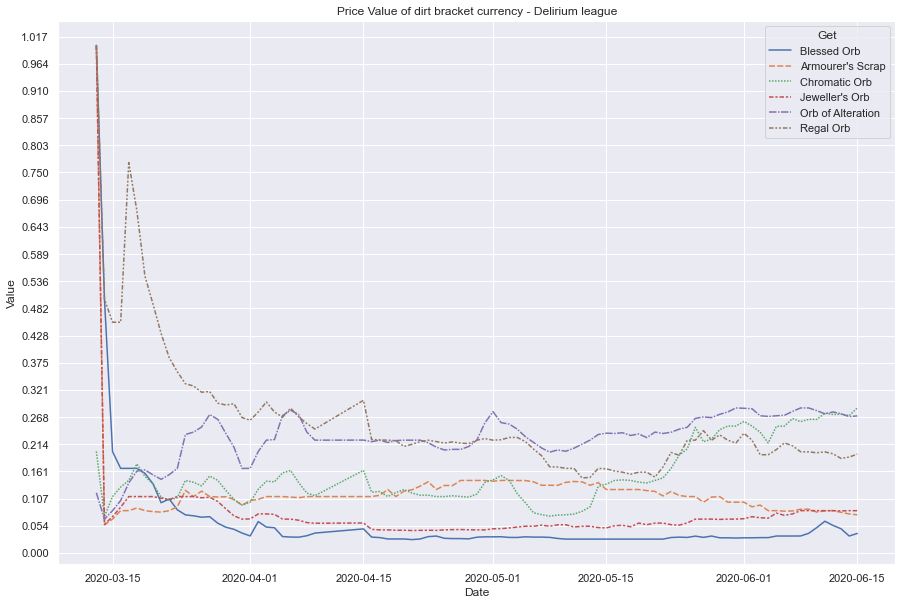

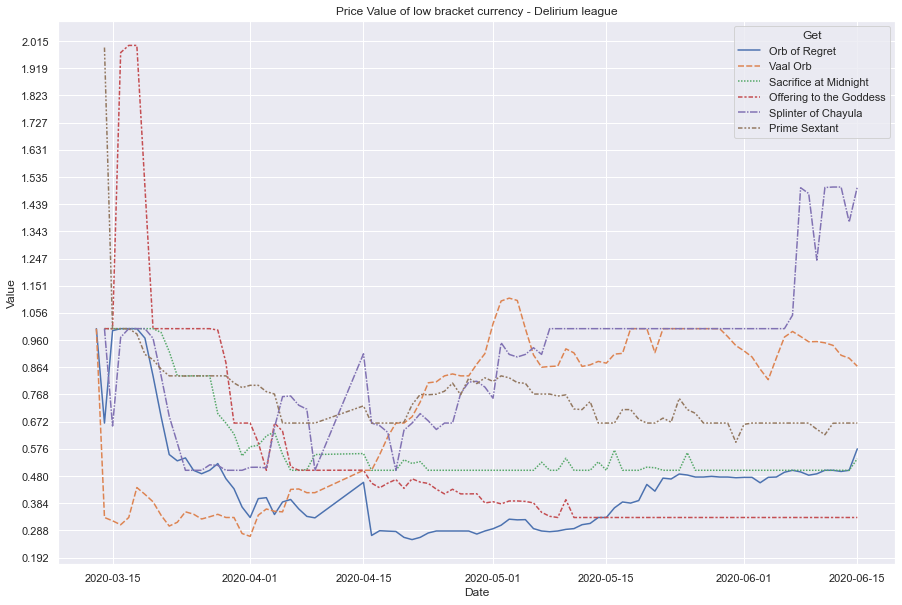

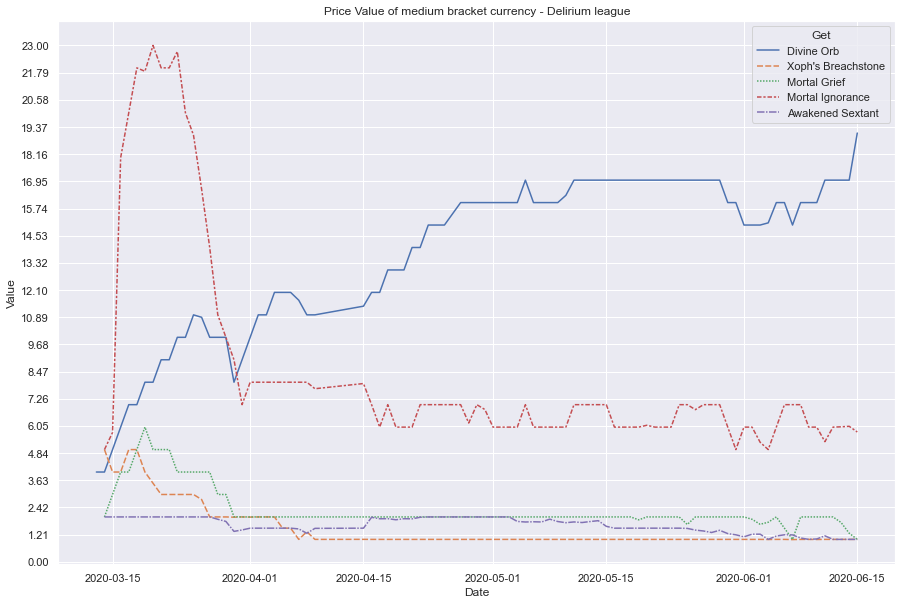

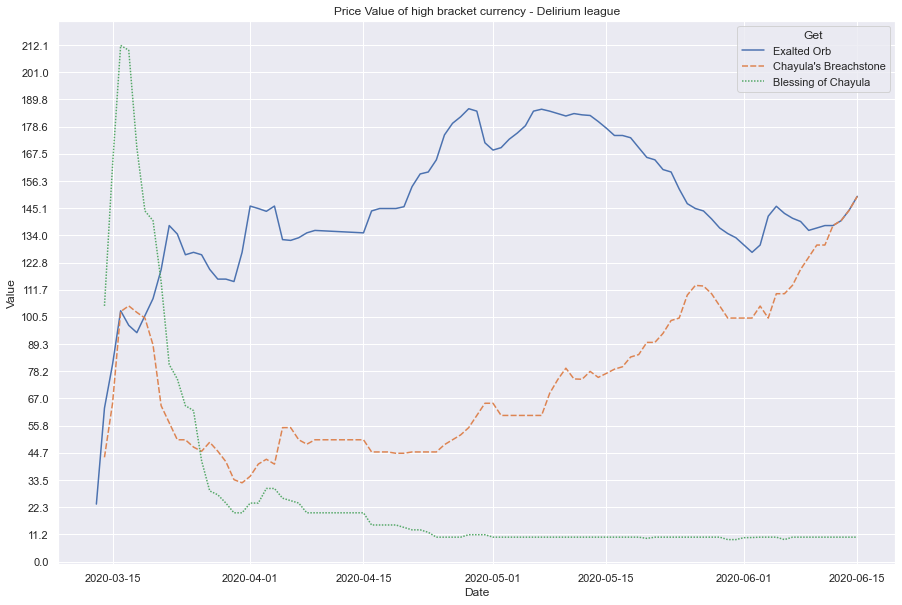

In [22]:
from matplotlib.ticker import MultipleLocator

def plot_currency_one_league(name, df: POEData, save_figure = True):
    figure = sns.lineplot(data=df,x='Date', y='Value', hue='Get', style='Get')
    
    ax = figure.axes
    ylim_low, ylim_high = ax.get_ylim()
    ax.yaxis.set_major_locator(MultipleLocator((ylim_high - ylim_low)/ 20))
    figure.set_title(f'Price Value of {name} bracket currency - {SAMPLE_LEAGUE_NAME} league')

    save_name = f'value_bracket_{name}_{SAMPLE_LEAGUE_NAME}.png'
    if save_figure: plt.savefig(f'{IMG_OUTPUT_PATH}/{save_name}', dpi=DPI_OUTPUT)
    plt.show()


for price_level in ['dirt', 'low', 'medium', 'high']:
    plot_currency_one_league(
        price_level,
        sample_currency[sample_currency['Get'].apply(lambda x: x in currencies_to_plot[price_level])]
    )

**Observations**
- No obvious trend within a league
- Item's value seems based solely on demand 
  - Ex: `Vaal Orb` Let user modify an item unexpectedly and lock any change afterwards -> very risky, so player only tend to use it later in the league, thus the price go up a bit when time passes
  - Ex: `Exalted Orb` is a useful currency and is always very on high demand -> price always rise and only drop later in the league when player interest drop
  - Ex: `Offering to the Goddess` useful early in the league when player need the item to level up their character fast and since player tend to switch character early on, but price soon drop and level as time go on since player will focus on one character later in the league

### Correlation
- Only one feature: `value`
- So no correlation can be calculated

## Currency Seasonal Time Series
In this part, let's pick some notable currencies and see how they fluctuate in different leagues

In [23]:
currencies_to_check_seasonal = INTERESTING_CURRENCIES

### Seasonal Plot

In [24]:

def plot_currency_seasonal(name, data: dict, leagues, save_figure = True, figsize = (30, 20)):
    figure = plt.figure(figsize=figsize)
    ax = figure.add_subplot(1,1,1)
    for league in leagues:
        df = data[league].event.currency.sort_values('Date')
        df = df[df['Get'] == name]
        # print(league)
        # display(df.head(10))
        sns.lineplot(data = df['Value'].reset_index(drop=True), label= league, ax = ax)

    ylim_low, ylim_high = ax.get_ylim()
    ax.yaxis.set_major_locator(MultipleLocator((ylim_high - ylim_low)/ 20))
    figure.suptitle(f'{name} Seasonality Over Leagues')

    save_name = f'value_seasonal_{name}.png'
    if save_figure: plt.savefig(f'{IMG_OUTPUT_PATH}/{save_name}', dpi=DPI_OUTPUT)
    plt.show()

**First let's see if our seasonal graph is correct**

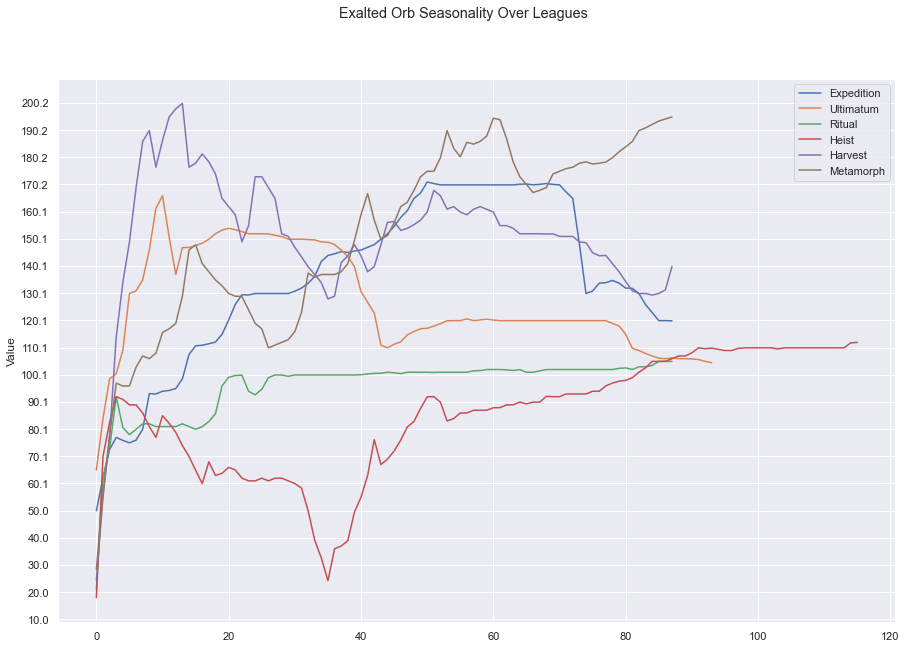

In [25]:
plot_currency_seasonal('Exalted Orb', DATA, leagues = ['Expedition', 'Ultimatum', 'Ritual', 'Heist', 'Harvest', 'Metamorph'], figsize=(15,10))

- As introduced in `RelatedAPIs.ipynb`, there's a site called `poe-antiquary.xyz` that also help to plot historical market data
- Here's the same `Exalted Orb` plotted from that site


![image](./images/poe_exalted_price.png)

It can be seen that the data is relatively same, not exact since the data source of `poe-antiquary` is different from `poe.ninja`, it's probably because of the mean calculation method also

**Now let's see the seasonal data for some currencies from some random selected leagues**

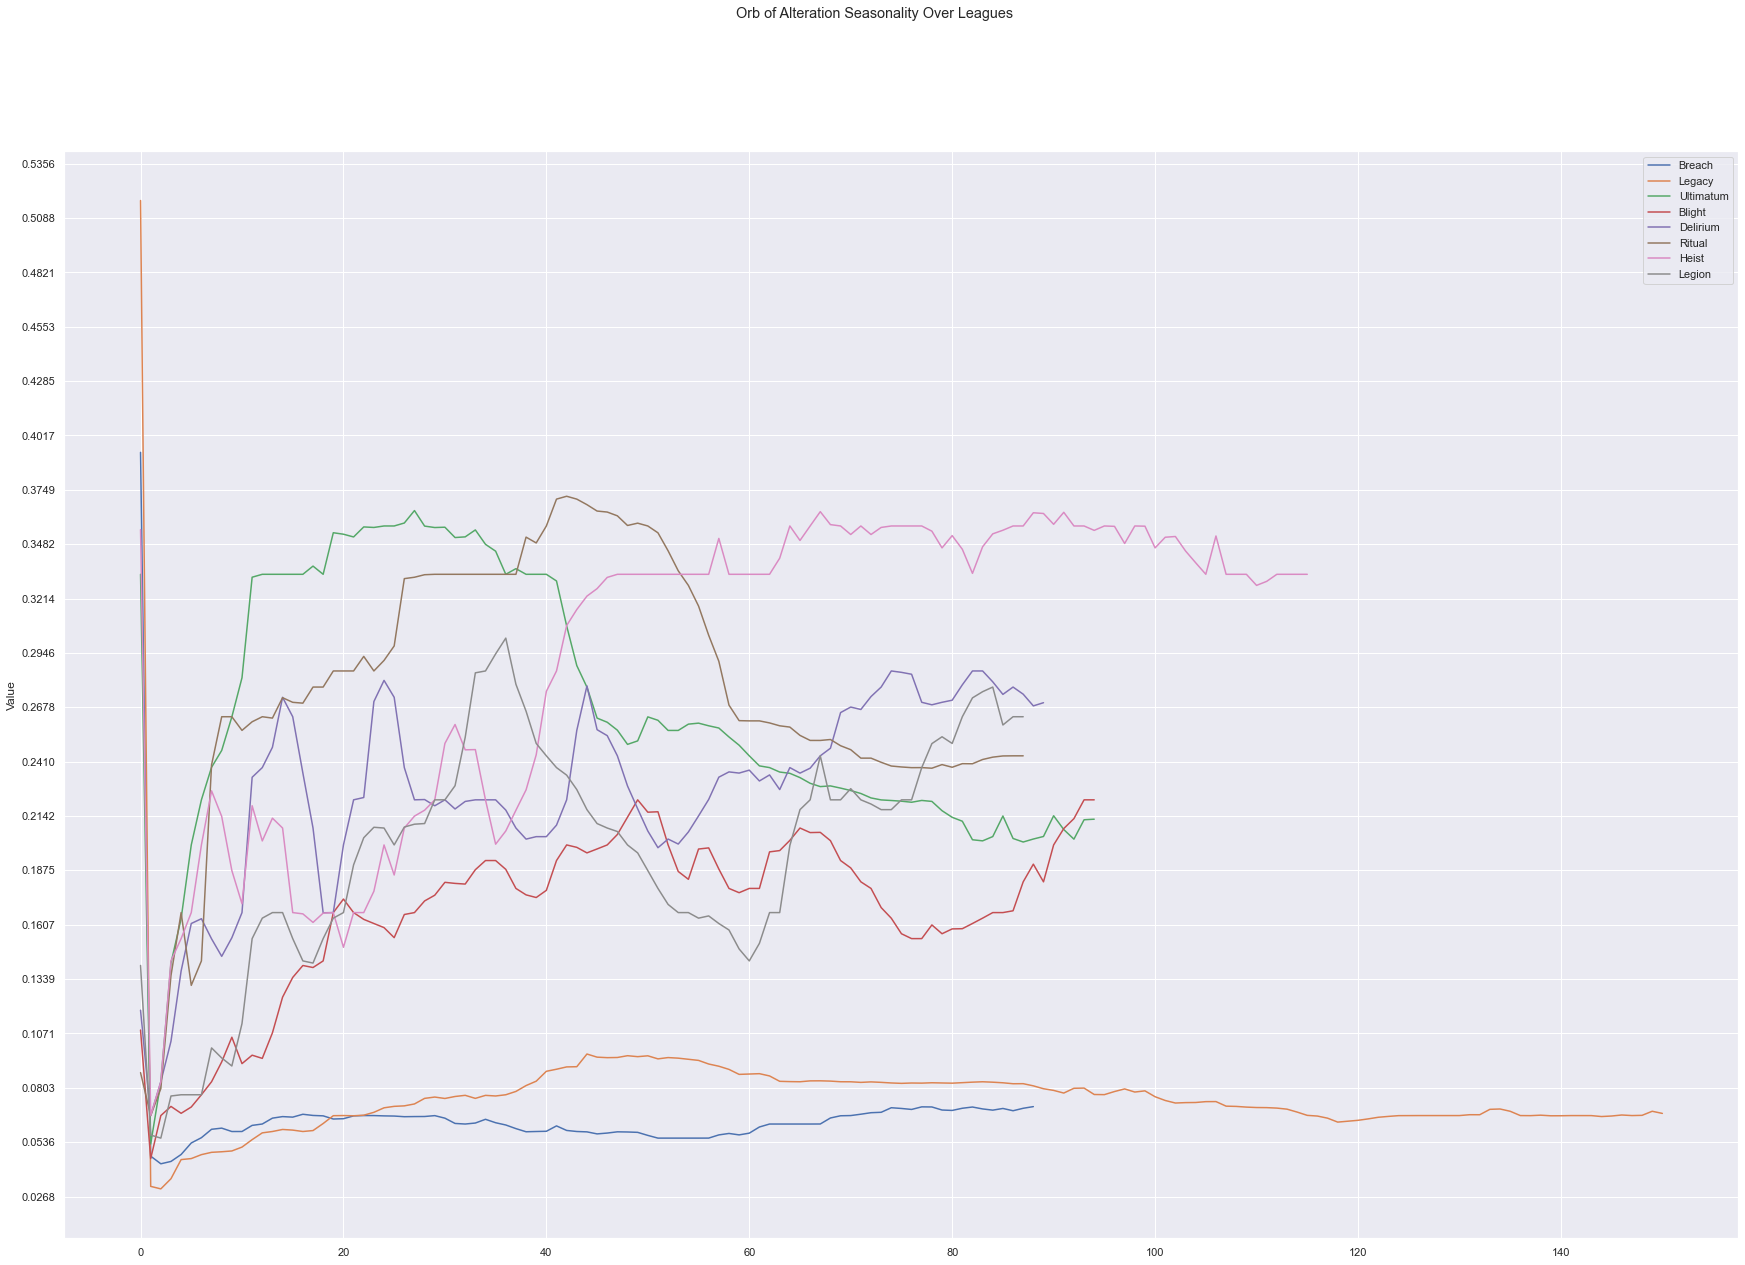

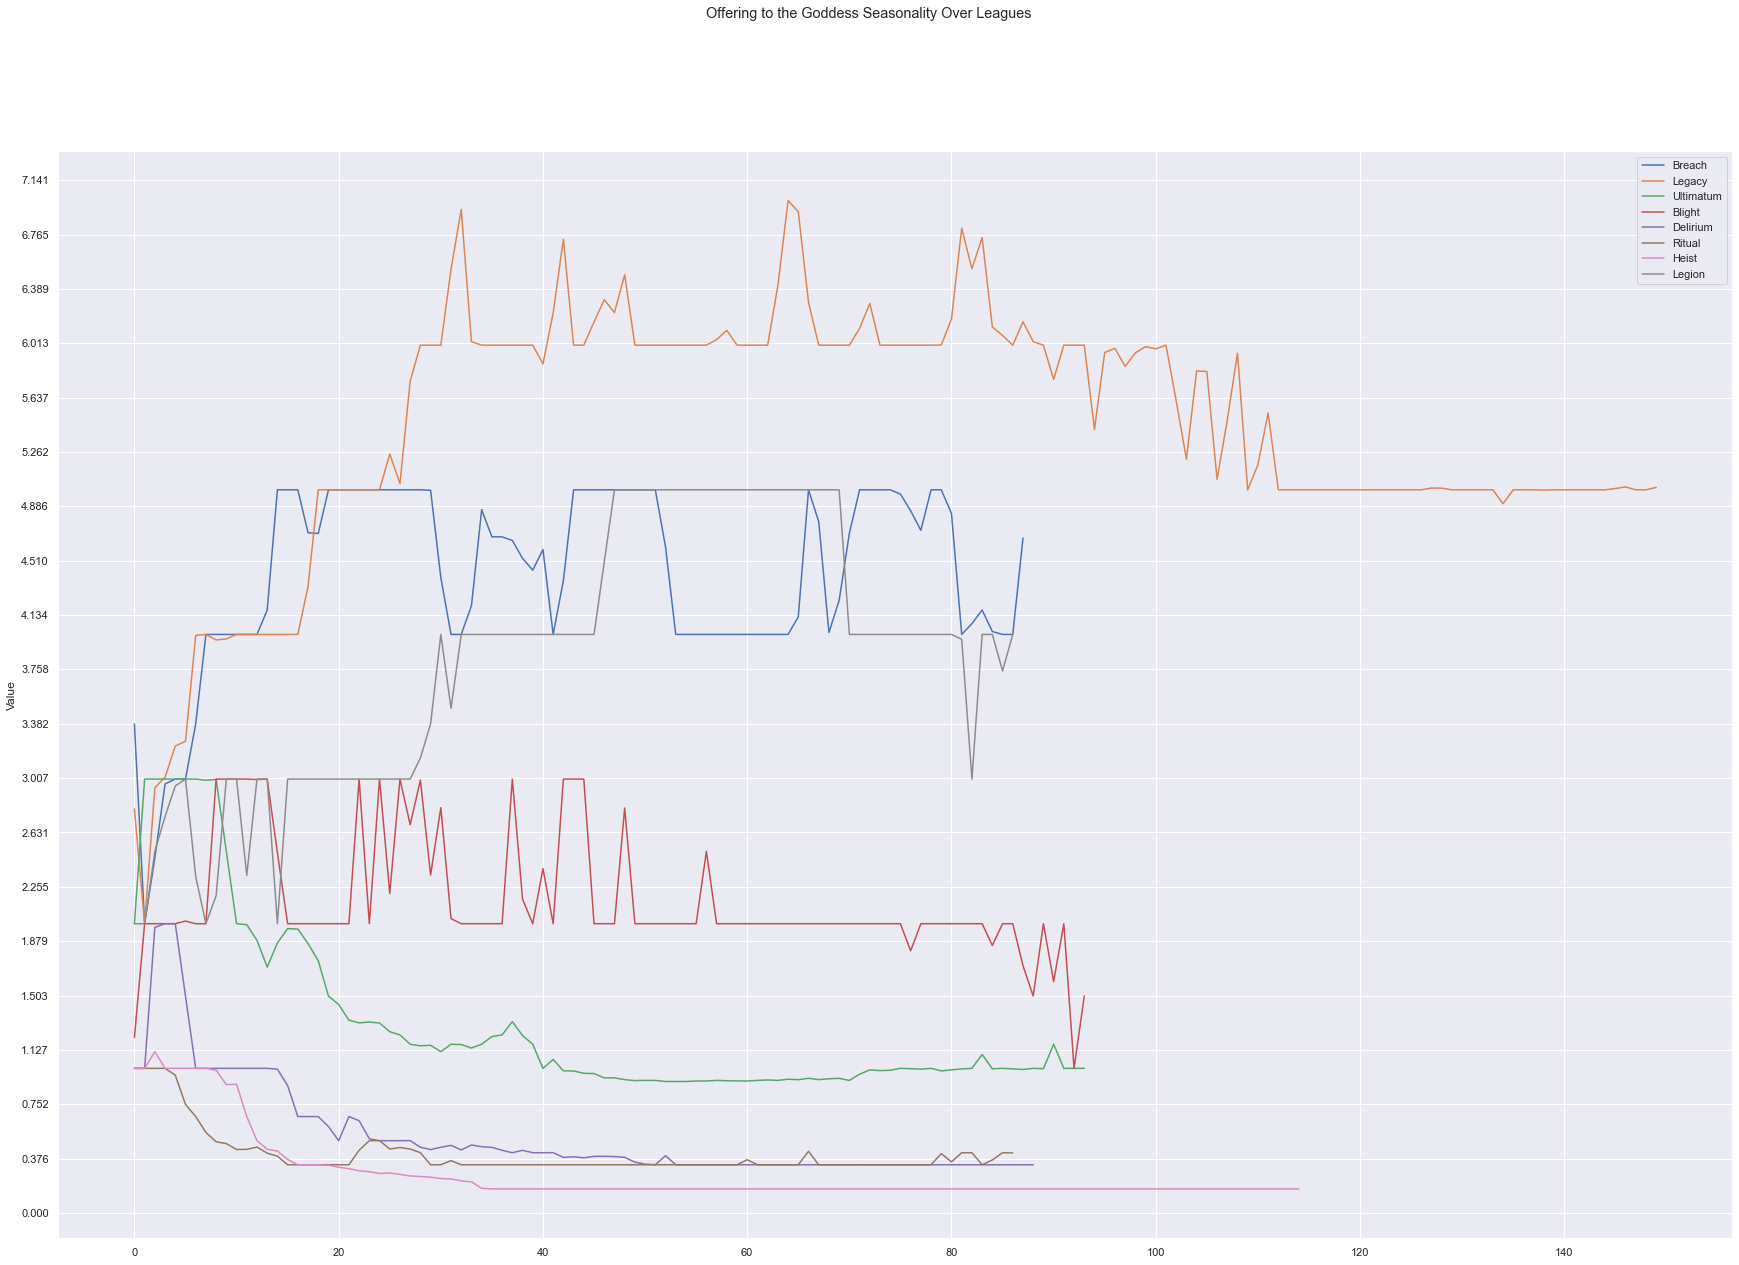

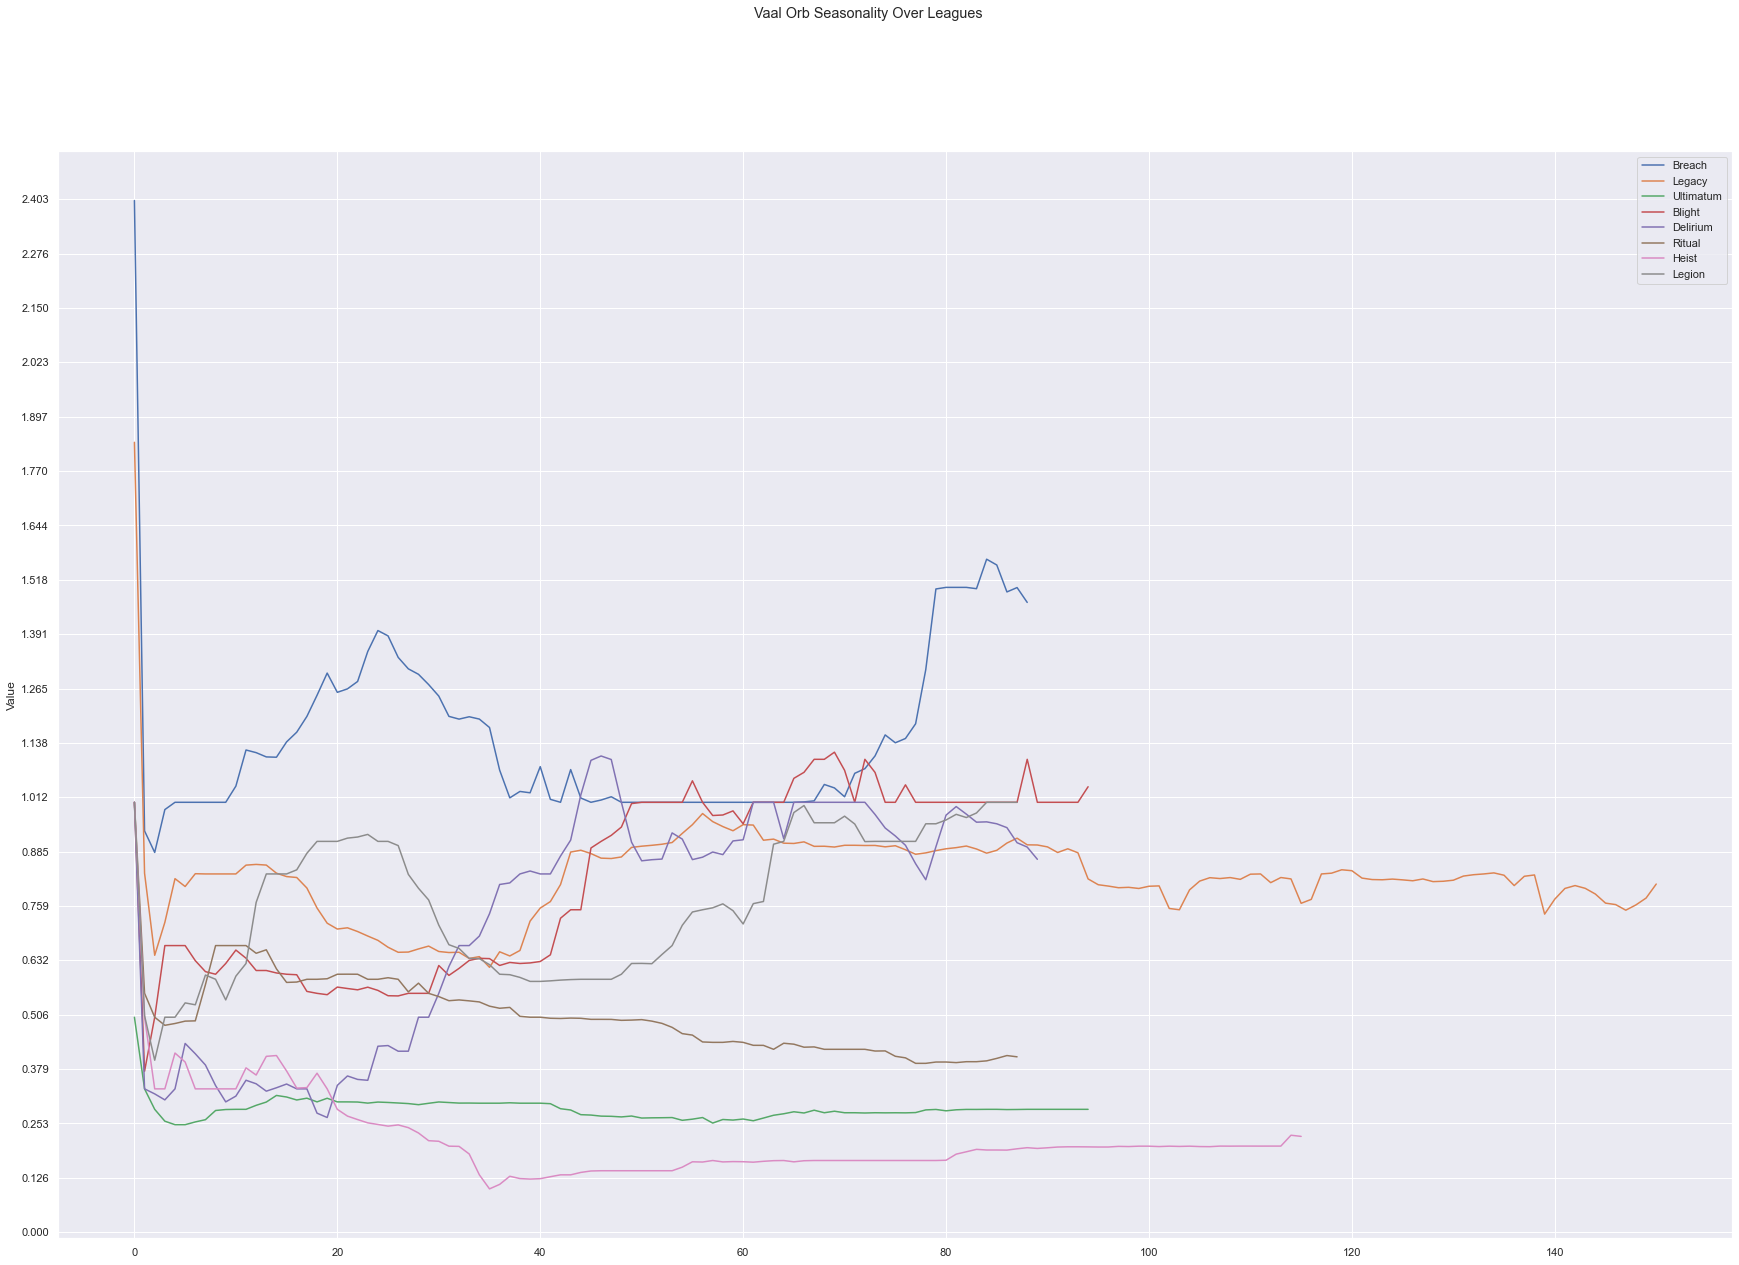

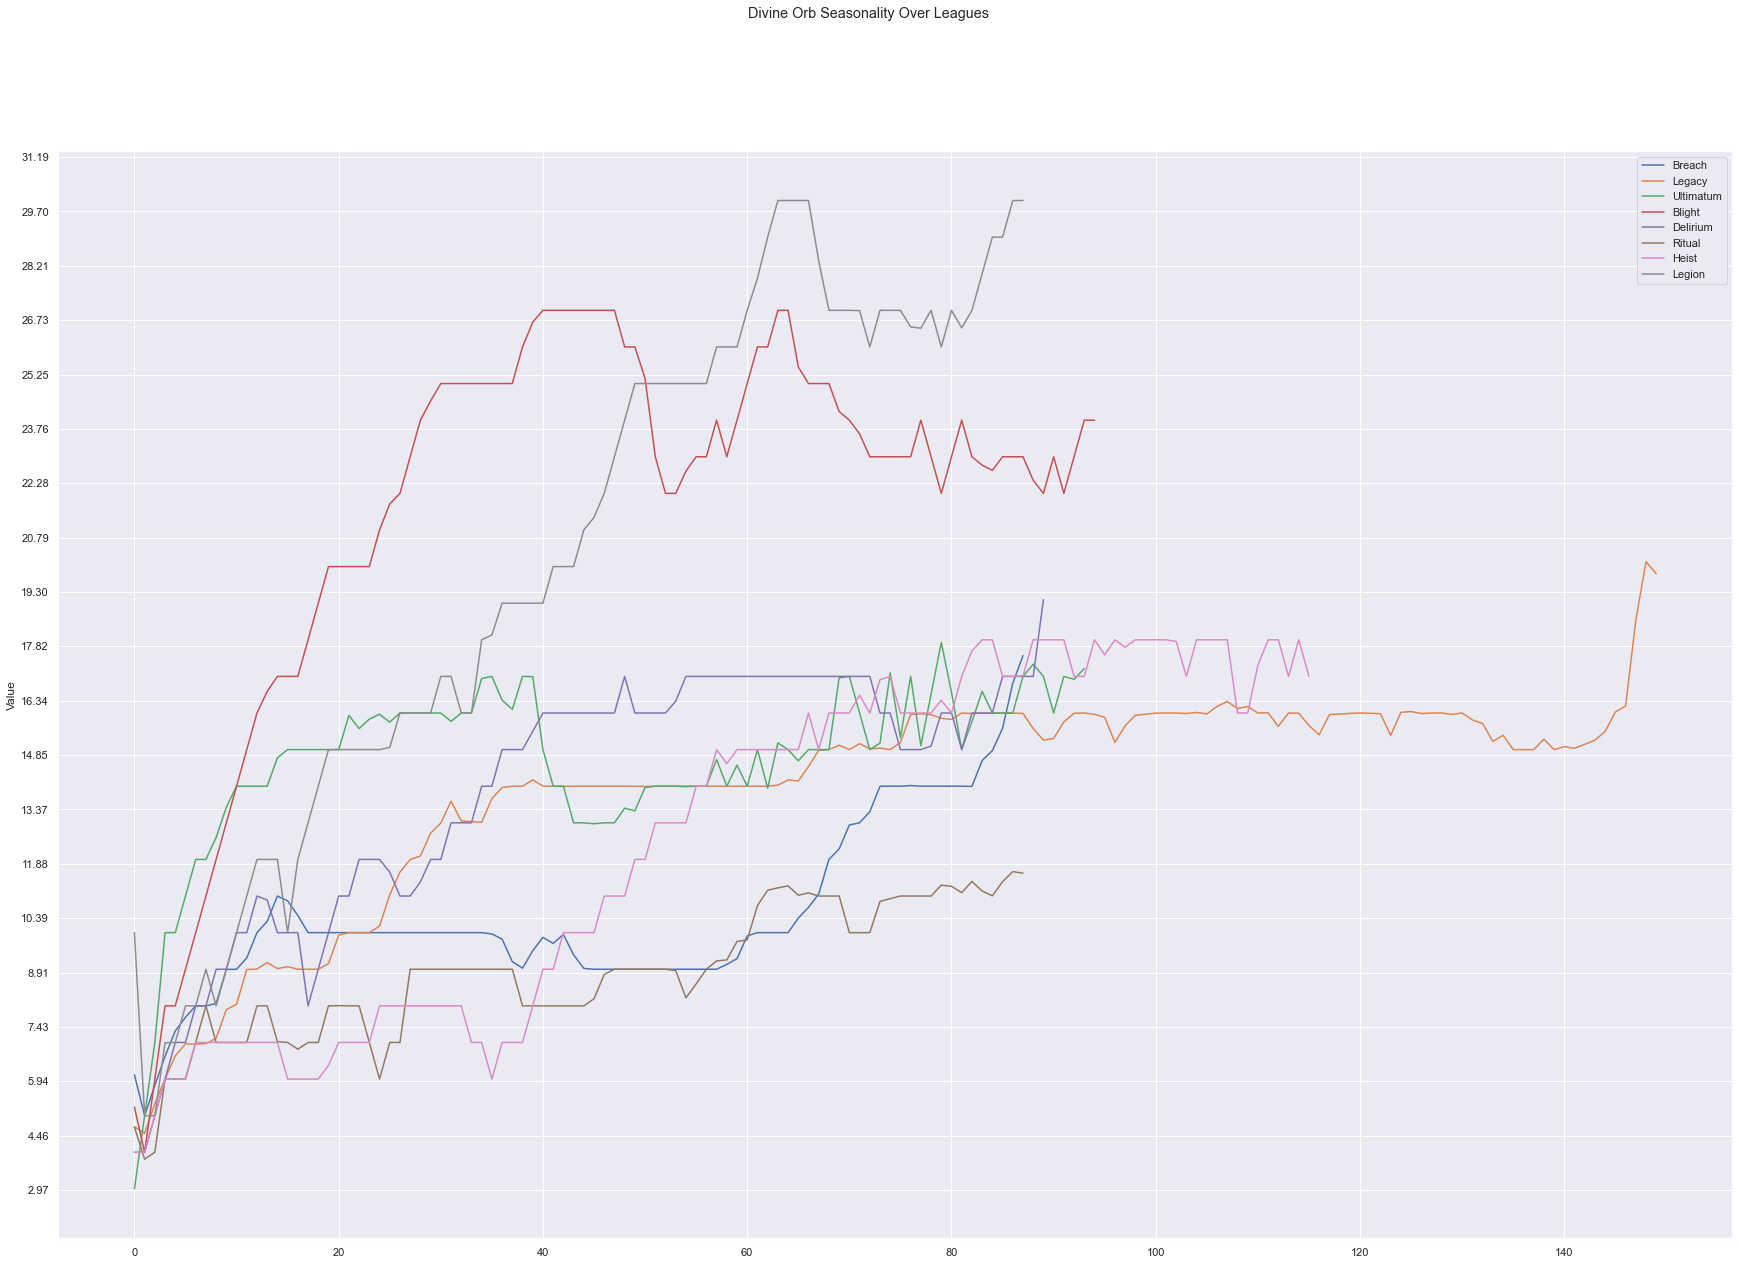

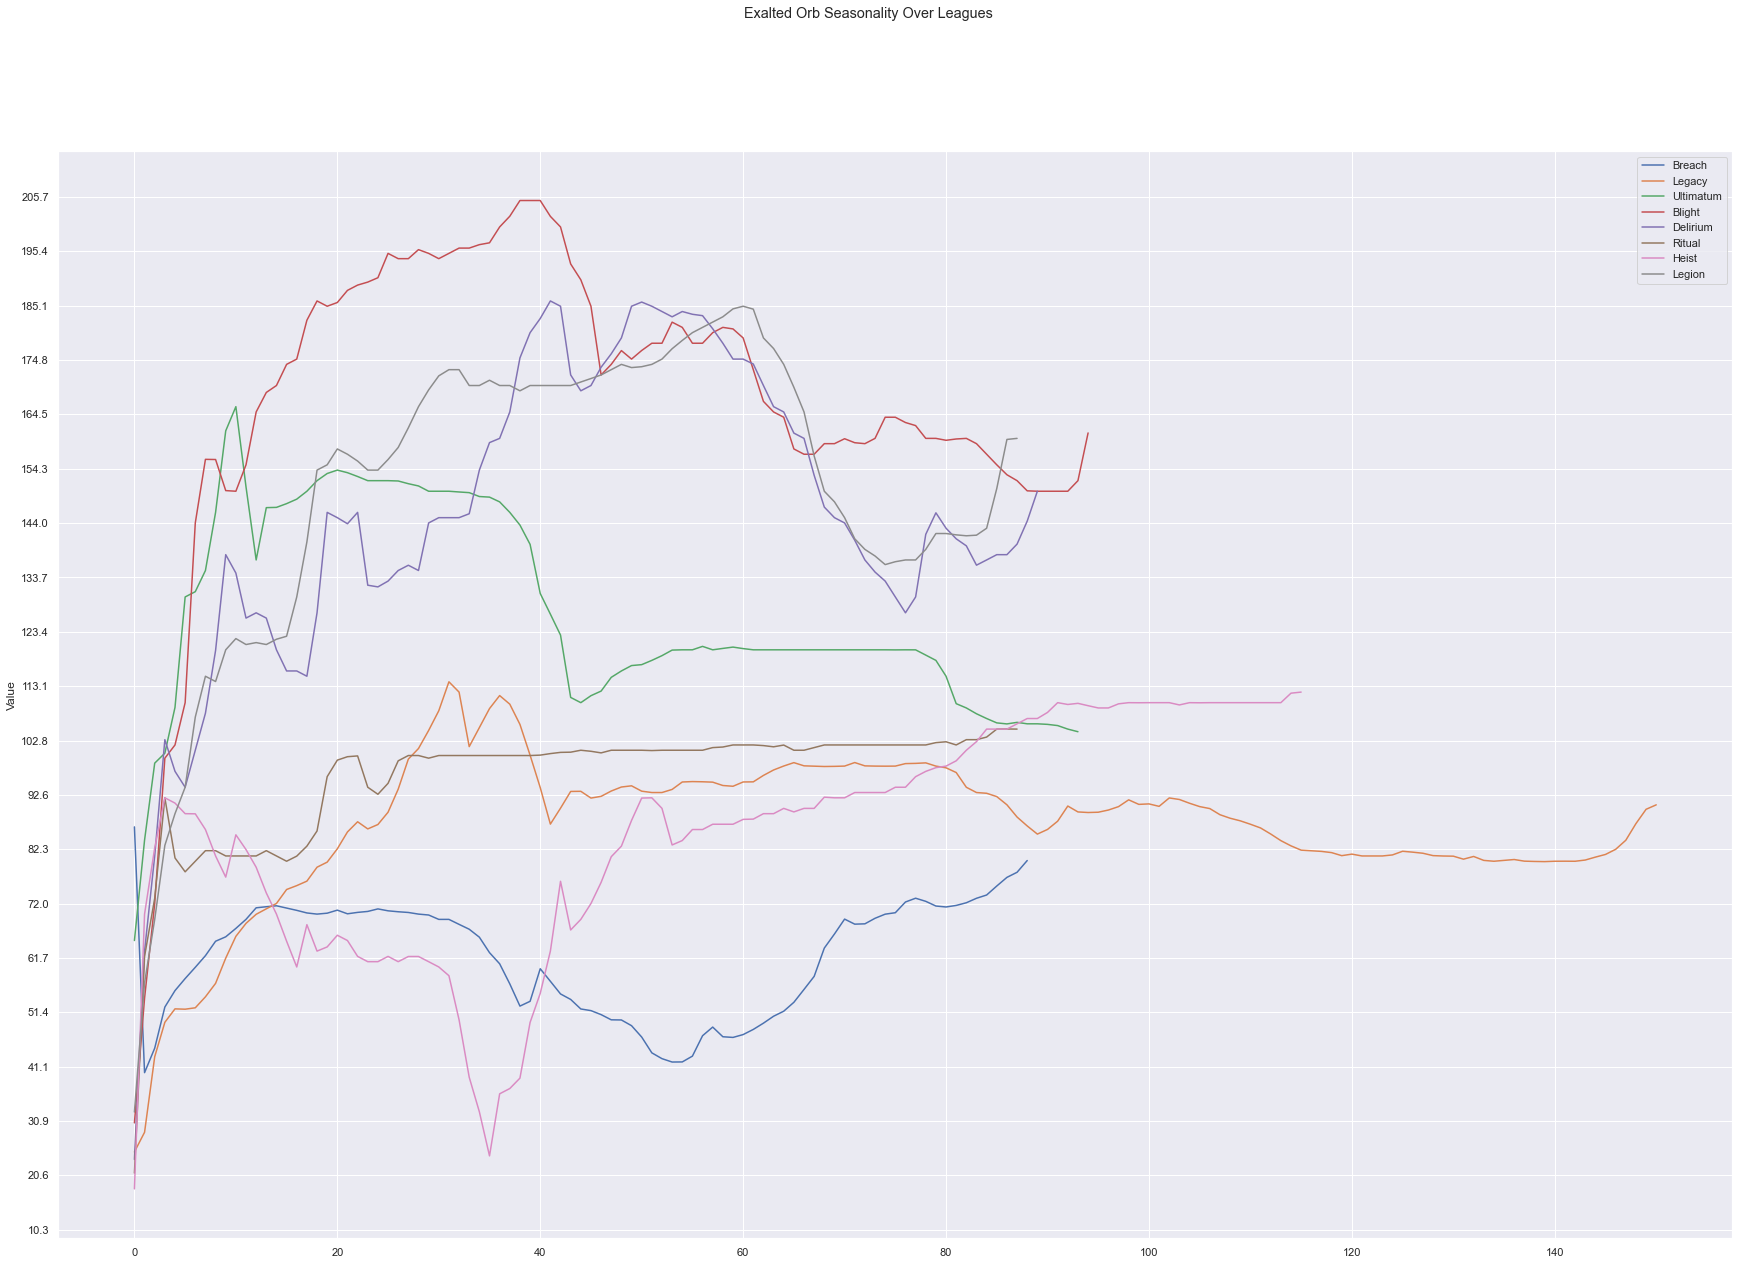

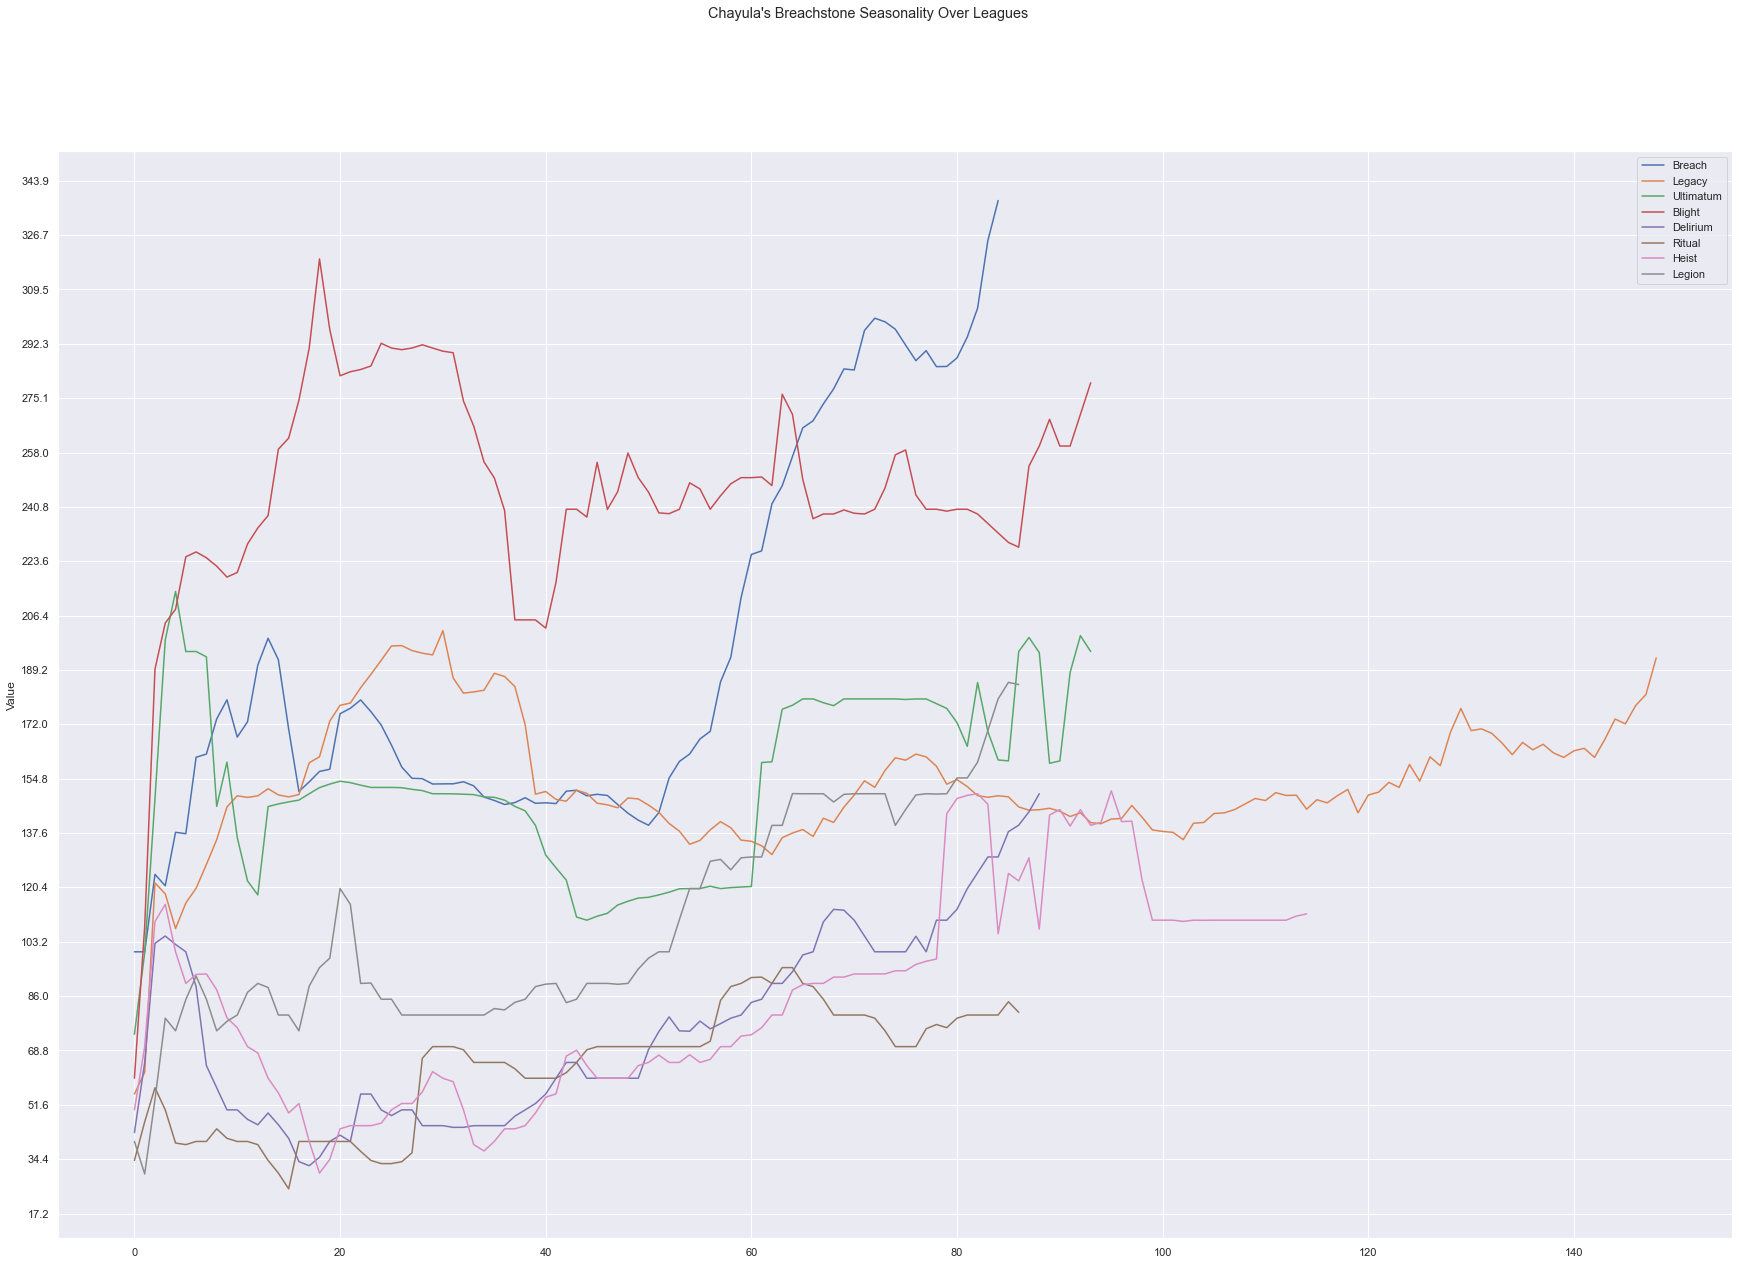

In [26]:
for c in currencies_to_check_seasonal:
    plot_currency_seasonal(c, data = DATA, leagues = REDUCED_LEAGUES)

### Conclusion on Seasonality
- **`No obvious seasonality`**
- But, some seasonality can be observed:
  - Ex: `Exalted Orb`: spike at start league and level down
  - Ex: `Divine Orb`: rise and level

## Trend

- Though it is quite natural that our data does not include any trend
- Due to the fact that leagues are reset and things start over from scratch
- This suggest that there must be no upward or downward trend 

**Still we should plot to see it better**

In [27]:

def plot_currency_trend(name, data: dict, leagues, save_figure = True, figsize = (100, 10)):
    merged_df = pd.concat(
        [get_currency_data(name, data, league) for league in leagues]
    ).reset_index(drop=True).sort_values('Date')

    if len(merged_df['Date'].unique()) != len(merged_df['Date']): raise Exception()

    figure = plt.figure(figsize=figsize)
    ax = figure.add_subplot(1,1,1)
    sns.lineplot(data=merged_df,x='Date', y='Value', hue='League', style='League')
    
    ylim_low, ylim_high = ax.get_ylim()
    ax.yaxis.set_major_locator(MultipleLocator((ylim_high - ylim_low)/ 20))
    figure.suptitle(f'Value over time of {name} (trend)')

    save_name = f'value_trend_{name}.png'
    if save_figure: plt.savefig(f'{IMG_OUTPUT_PATH}/{save_name}', dpi=DPI_OUTPUT)
    plt.show()

Trend of:  Orb of Alteration


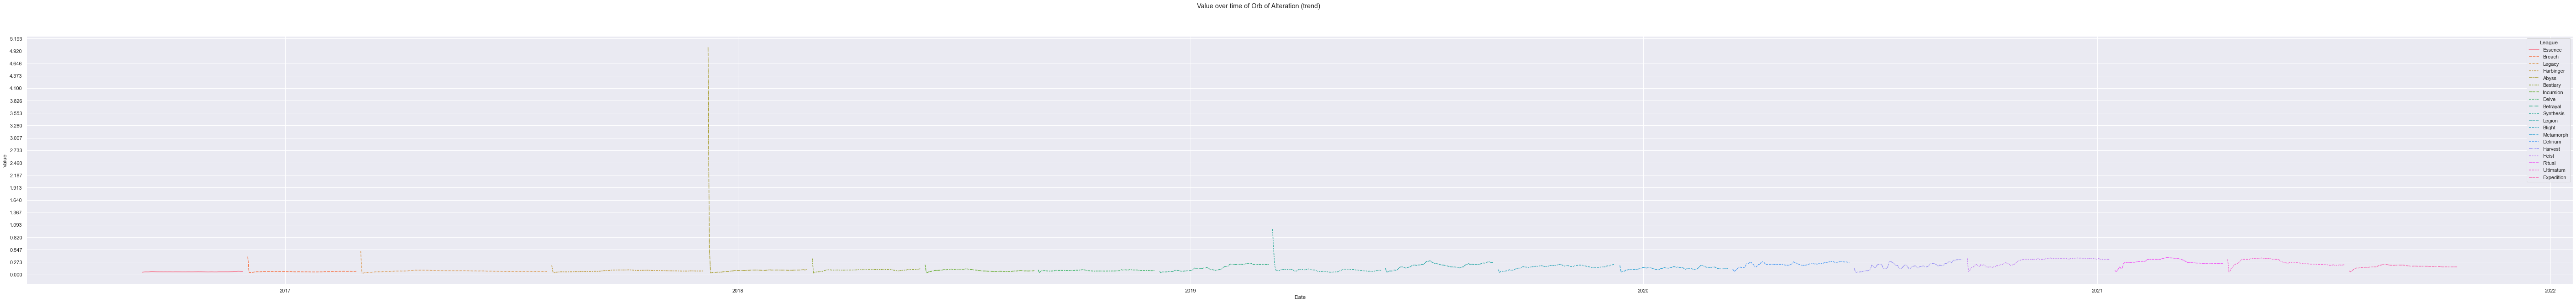

Trend of:  Offering to the Goddess


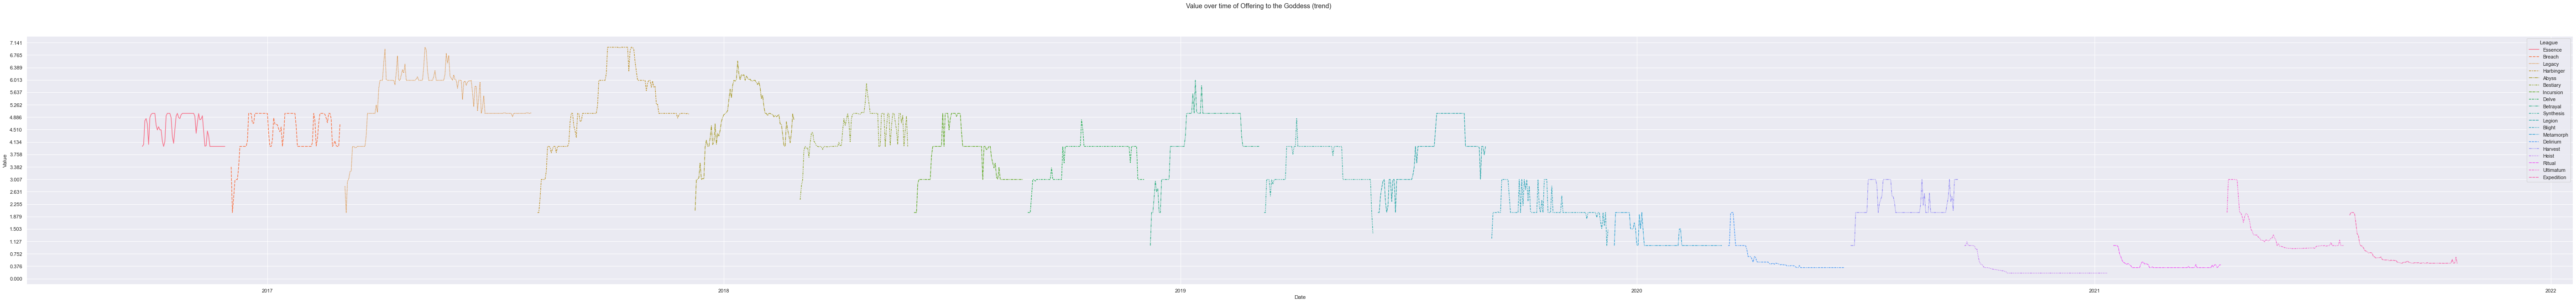

Trend of:  Vaal Orb


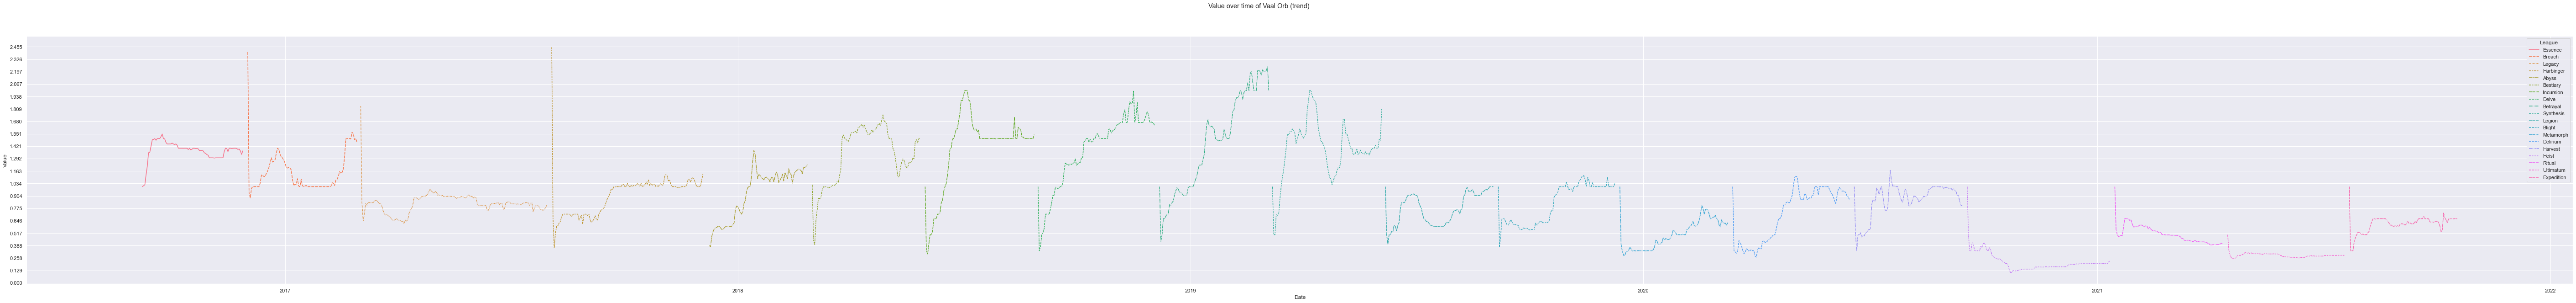

Trend of:  Divine Orb


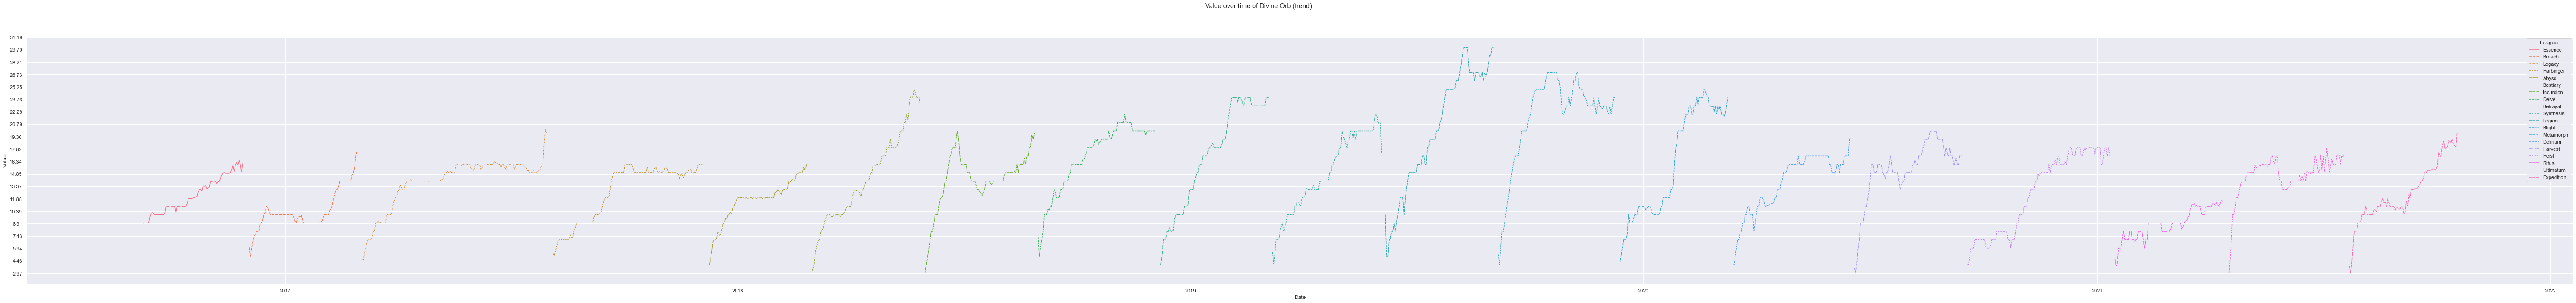

Trend of:  Exalted Orb


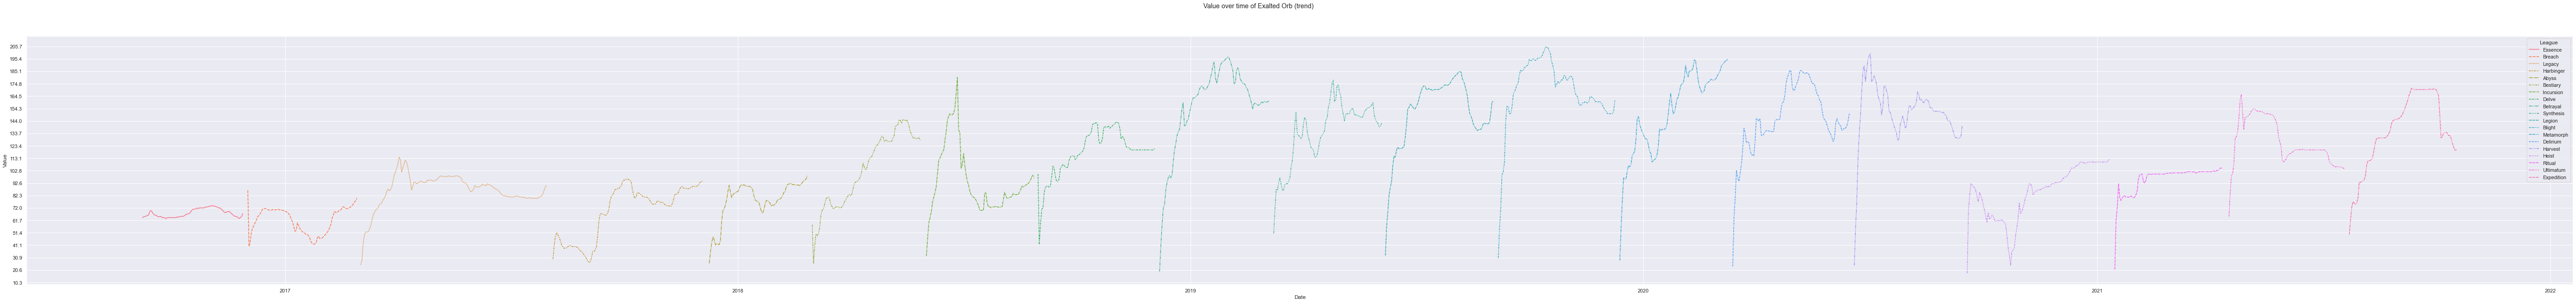

Trend of:  Chayula's Breachstone


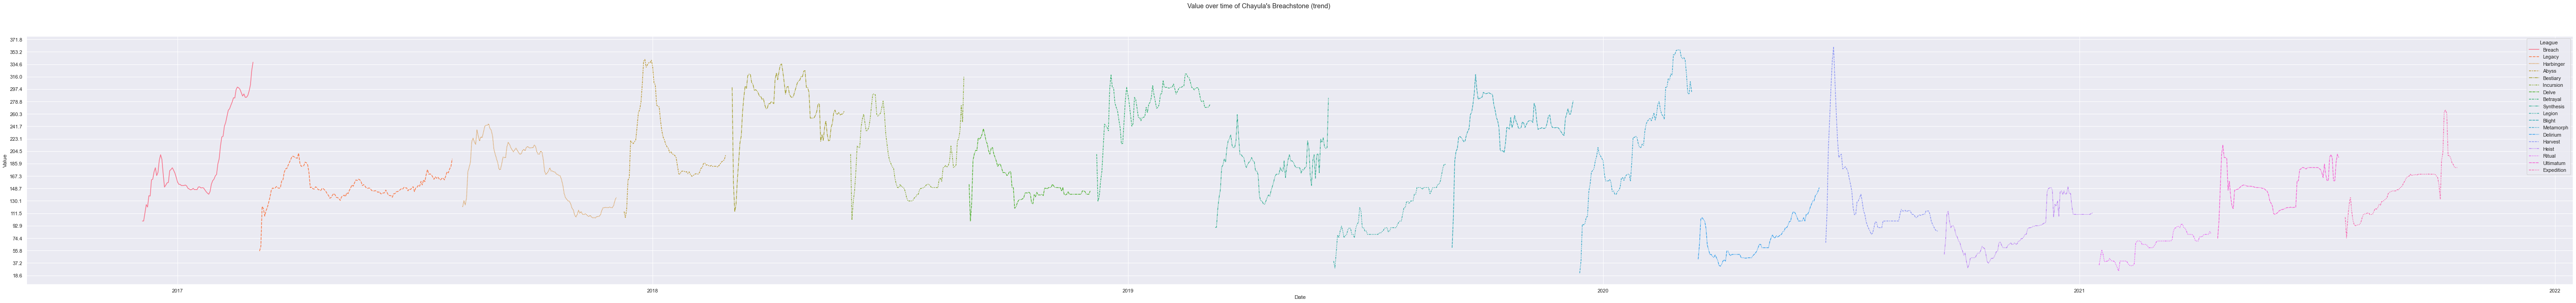

In [28]:
currencies_to_check_trend = INTERESTING_CURRENCIES
for c in currencies_to_check_trend:
    print('Trend of: ', c)
    plot_currency_trend(c, data = DATA, leagues = LEAGUES)

### Conclusion for trend
- **View images in the `images/output` folder for better resolution**
- **`No clear trend as expected`**
- Though some items does seem to have tendency to get lower value over leagues due to new items being introduced, thus making old ones obsolete

## Autocorrelation

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

def concat_currency_data_from_leagues(name, data, leagues):
    merged_df = pd.concat(
        [get_currency_data(name, data, league) for league in leagues]
    ).reset_index(drop=True).sort_values('Date')
    
    return merged_df
def plot_currency_auto_correlation_concatinated(name, data, leagues, column = 'Value', figsize = (15,10), save_figure = True):
    df = concat_currency_data_from_leagues(name, data, leagues)
    figure, ax = plt.subplots(figsize = figsize)

    plot_acf(df[column], lags=1000, ax = ax)
    plt.title(f'Autocorrelation of {name} across all leagues - {df.shape}')
    ax.xaxis.set_major_locator(MultipleLocator(30))
    
    save_name = f'value_concatinated_autocor_{name}.png'
    if save_figure: plt.savefig(f'{IMG_OUTPUT_PATH}/{save_name}', dpi=DPI_OUTPUT)
    plt.show()

### Sample
Exalted orb

**Auto correlation across all the timeline (exalted)**

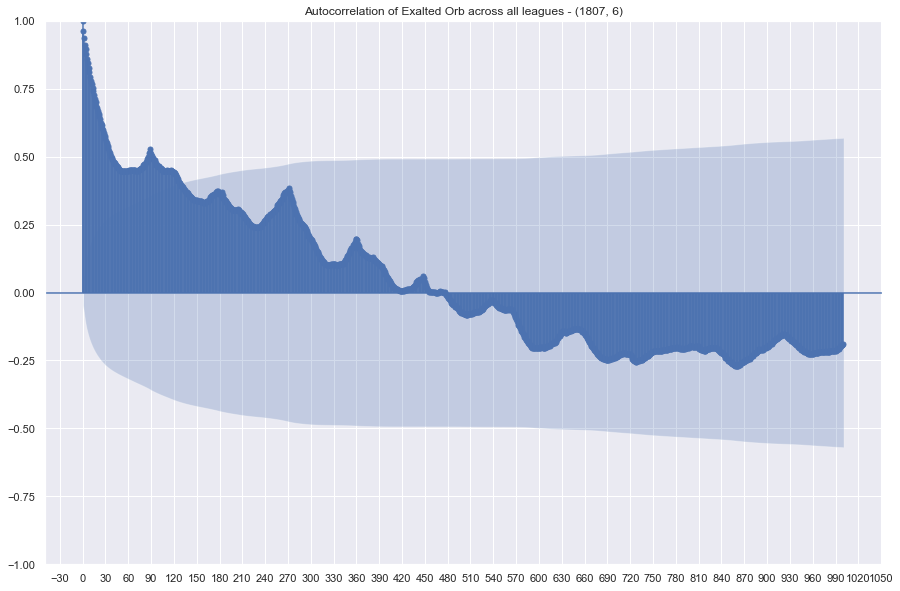

In [32]:
plot_currency_auto_correlation_concatinated('Exalted Orb', DATA, LEAGUES)

**`The slight seasonality can again be seen here where there's a spike and dim in correlation value in every 3 month period`**

**Autocor on each league (exalted)**

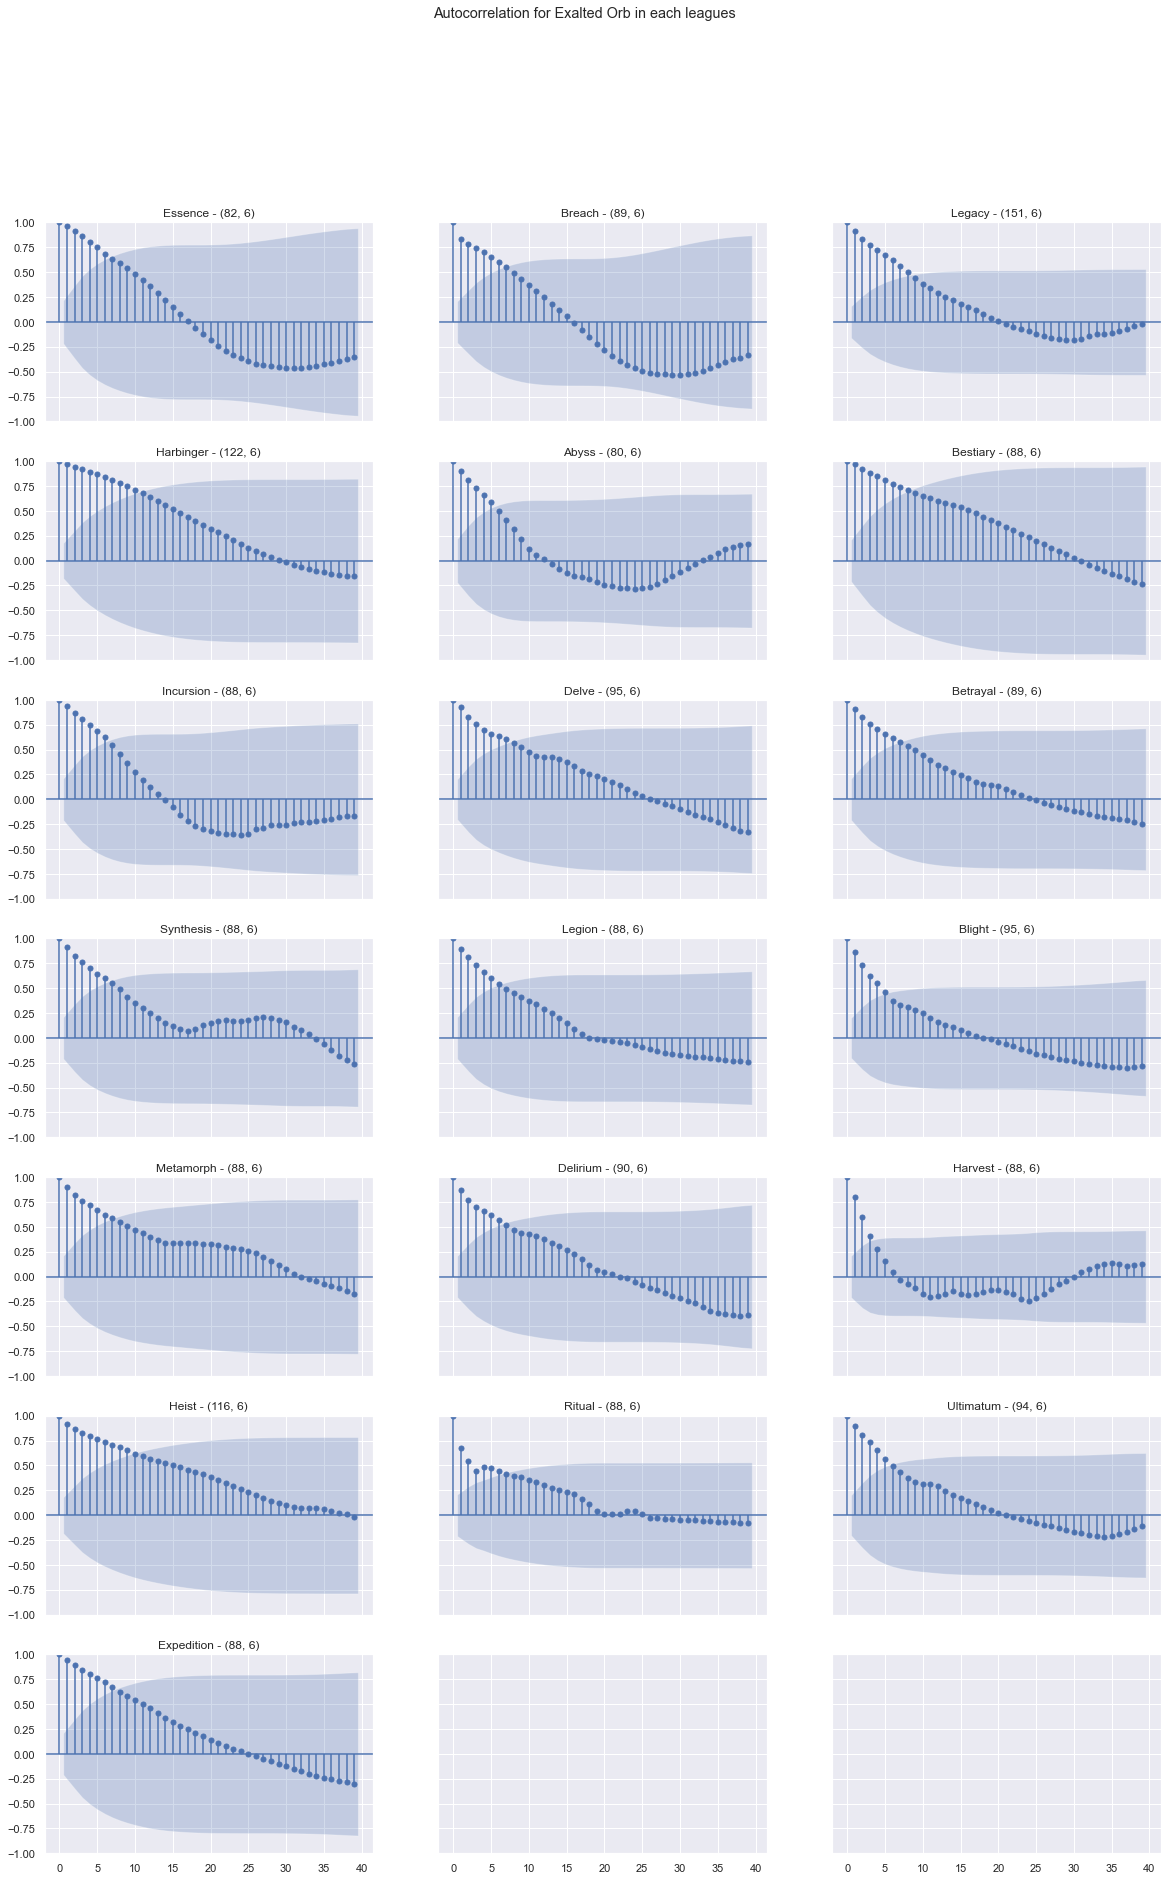

In [34]:
import math
def plot_currency_auto_correlation_leagues_in_grid(name, data, leagues, column = 'Value', figsize = (20,30), lags = 39, save_figure = True):
    league_count = len(leagues)
    n_cols = 3
    figure, axes = plt.subplots(math.ceil(league_count/float(n_cols)), n_cols, figsize = figsize, sharex = True, sharey = True)
    for league, ax in zip(leagues, axes.flatten()):
        df = get_currency_data(name, data,league)
        if df.empty: continue
        plot_acf(df[column], ax = ax, lags=lags)
        ax.set_title(f'{league} - {df.shape}')
    figure.suptitle(f'Autocorrelation for {name} in each leagues')
    
    save_name = f'value_each_league_autocor_{name}.png'
    if save_figure: plt.savefig(f'{IMG_OUTPUT_PATH}/{save_name}', dpi=DPI_OUTPUT)
    plt.show()

plot_currency_auto_correlation_leagues_in_grid('Exalted Orb', DATA, LEAGUES)

```
Most of these graphs have same correlation pattern, also suggesting seasonality
```

### More samples
Let's look at auto correlation on other currencies to see if there's a similar pattern

Autocor of:  Orb of Alteration


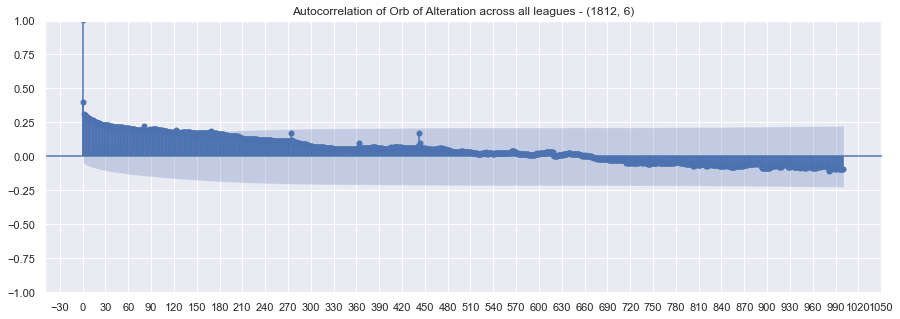

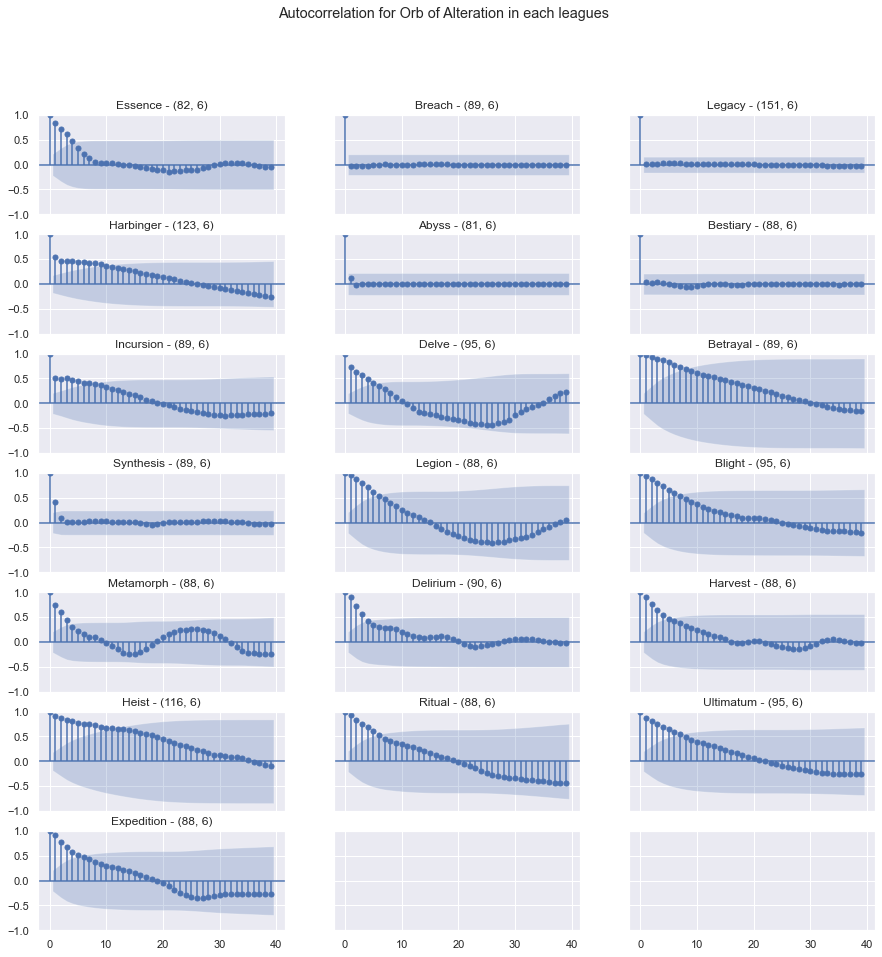

Autocor of:  Offering to the Goddess


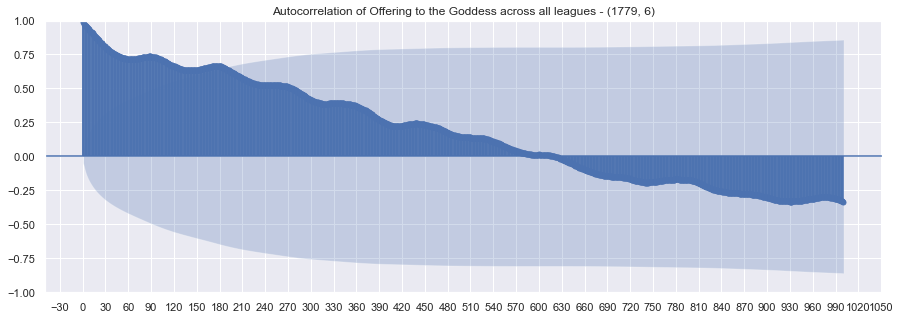

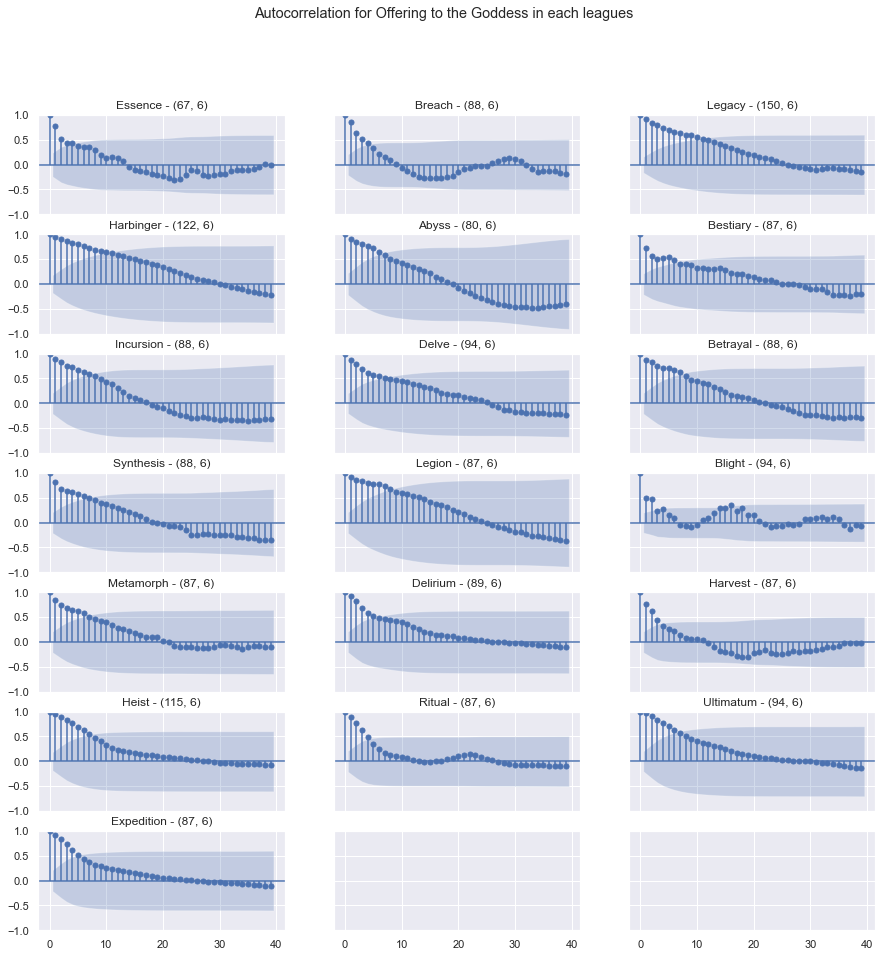

Autocor of:  Vaal Orb


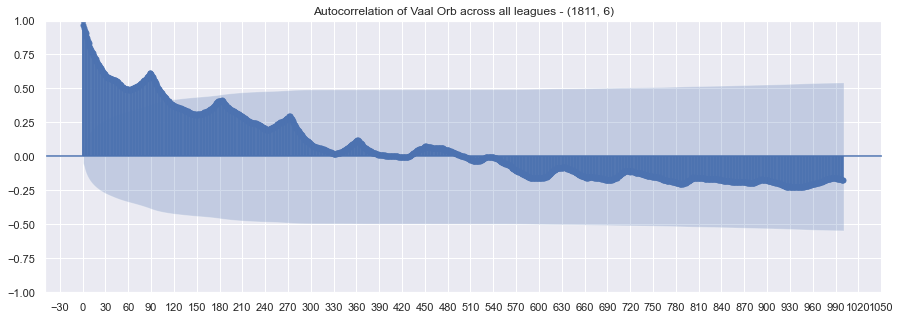

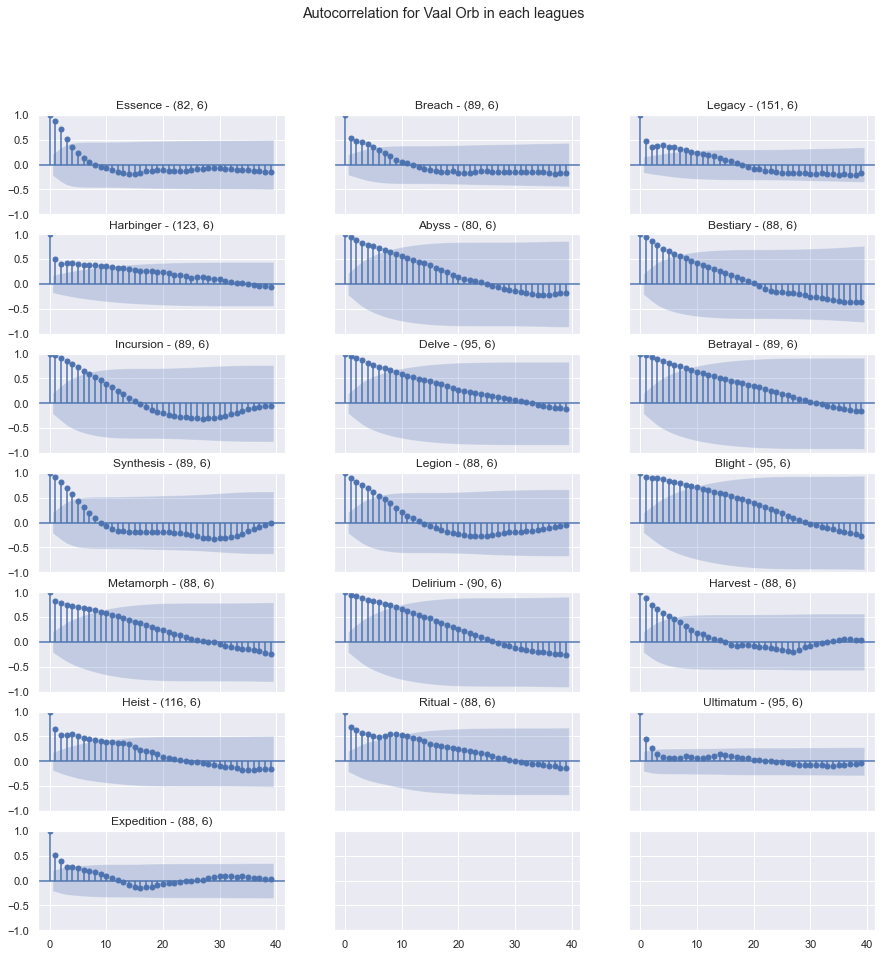

Autocor of:  Divine Orb


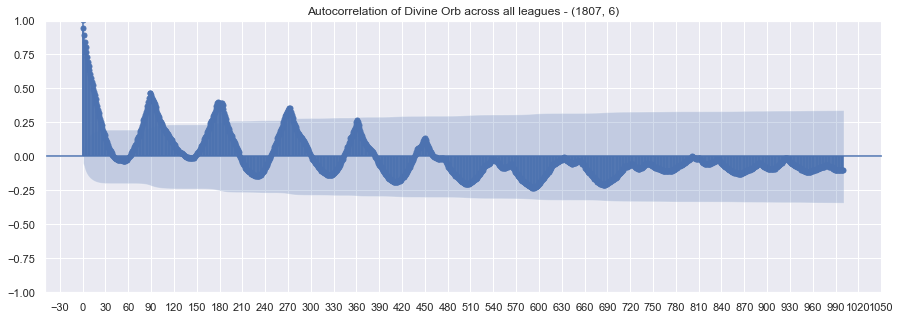

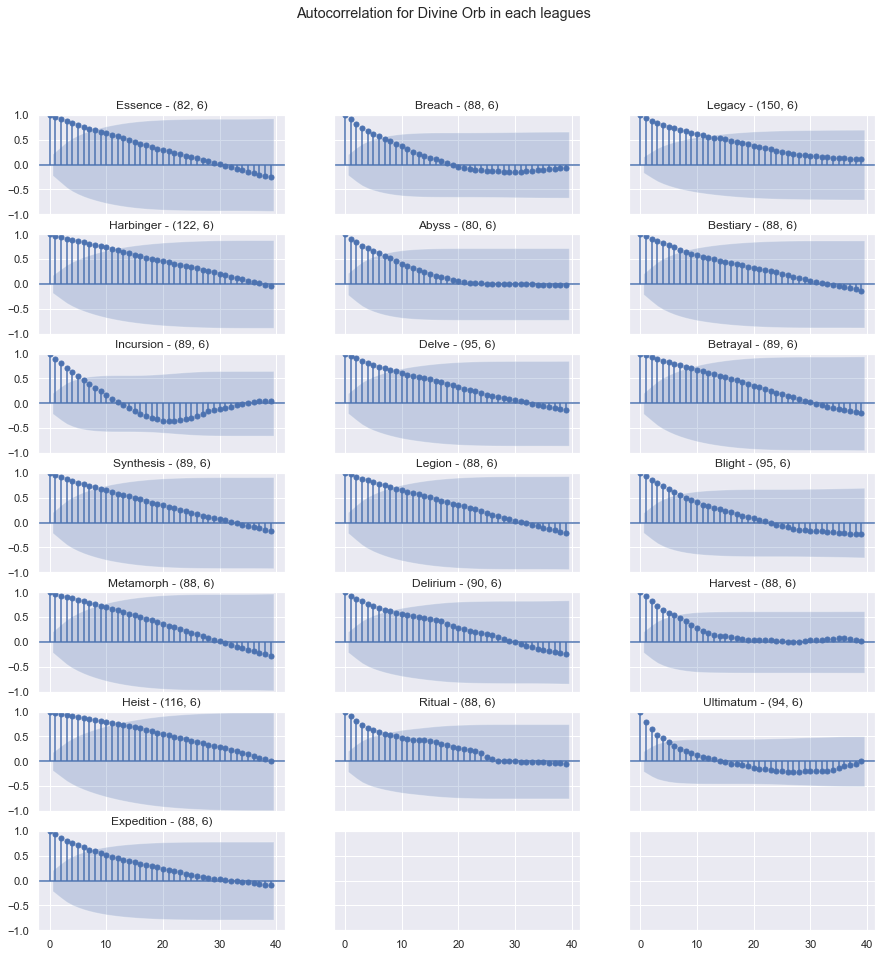

Autocor of:  Exalted Orb


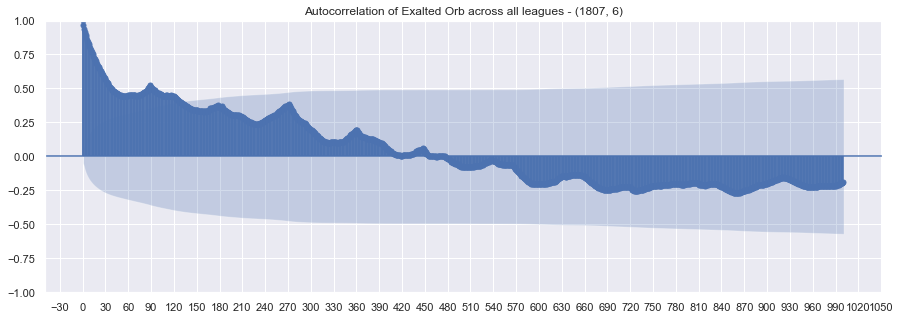

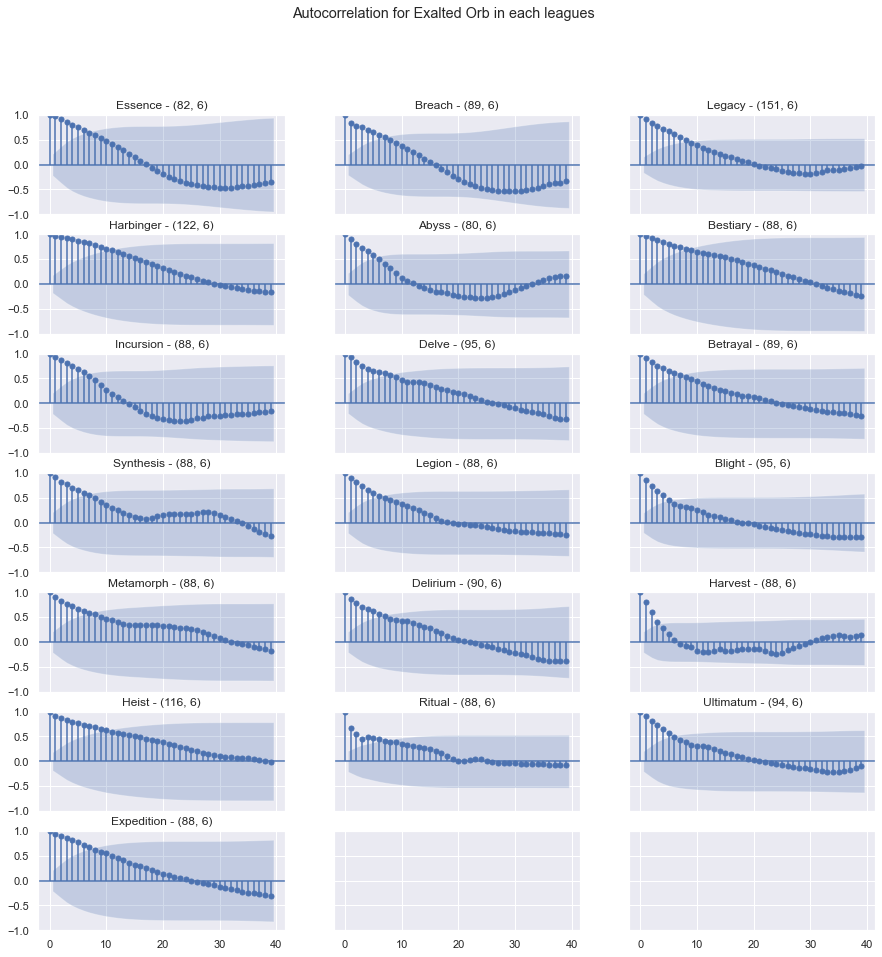

Autocor of:  Chayula's Breachstone


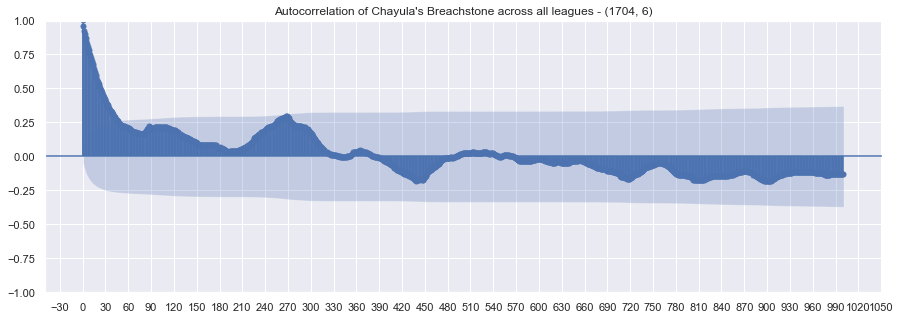

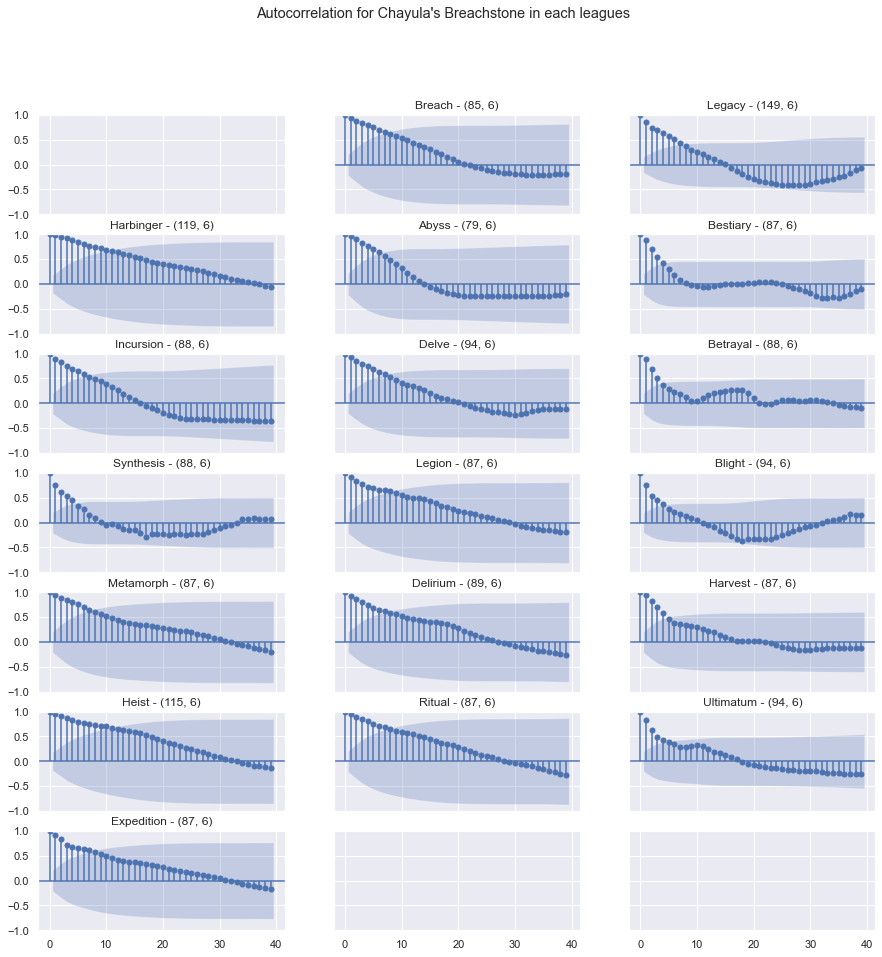

In [35]:
currencies_to_check_auto_cor = INTERESTING_CURRENCIES
for c in currencies_to_check_auto_cor:
    print('Autocor of: ', c)
    plot_currency_auto_correlation_concatinated(c, data = DATA, leagues = LEAGUES, figsize= (15,5))
    plot_currency_auto_correlation_leagues_in_grid(c, data = DATA, leagues = LEAGUES, figsize = (15,15))

## Partial autocorrelation

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf

def plot_currency_partial_auto_correlation_concatinated(name, data, leagues, column = 'Value', save_figure = True, figsize = (15,10)):
    figure, ax = plt.subplots(figsize=figsize)
    df = concat_currency_data_from_leagues(name, data, leagues)
    plot_pacf(df[column], lags=50, method='ywm', ax = ax)
    plt.title(f'Partial Autocorrelation of {name} across all leagues - {df.shape}')

    save_name = f'value_concatinated_partial_autocor_{name}.png'
    if save_figure: plt.savefig(f'{IMG_OUTPUT_PATH}/{save_name}', dpi=DPI_OUTPUT)
    plt.show()


### Sample
Exalted Orb

**Let's observe autocor of exalted orb over all leagues**

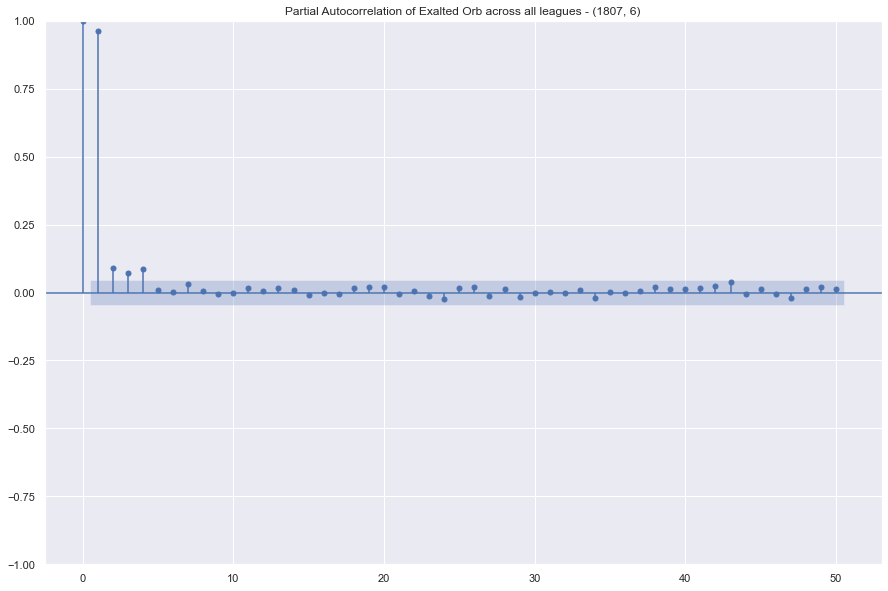

In [37]:
plot_currency_partial_auto_correlation_concatinated('Exalted Orb', DATA, LEAGUES)

**How about within each league?**

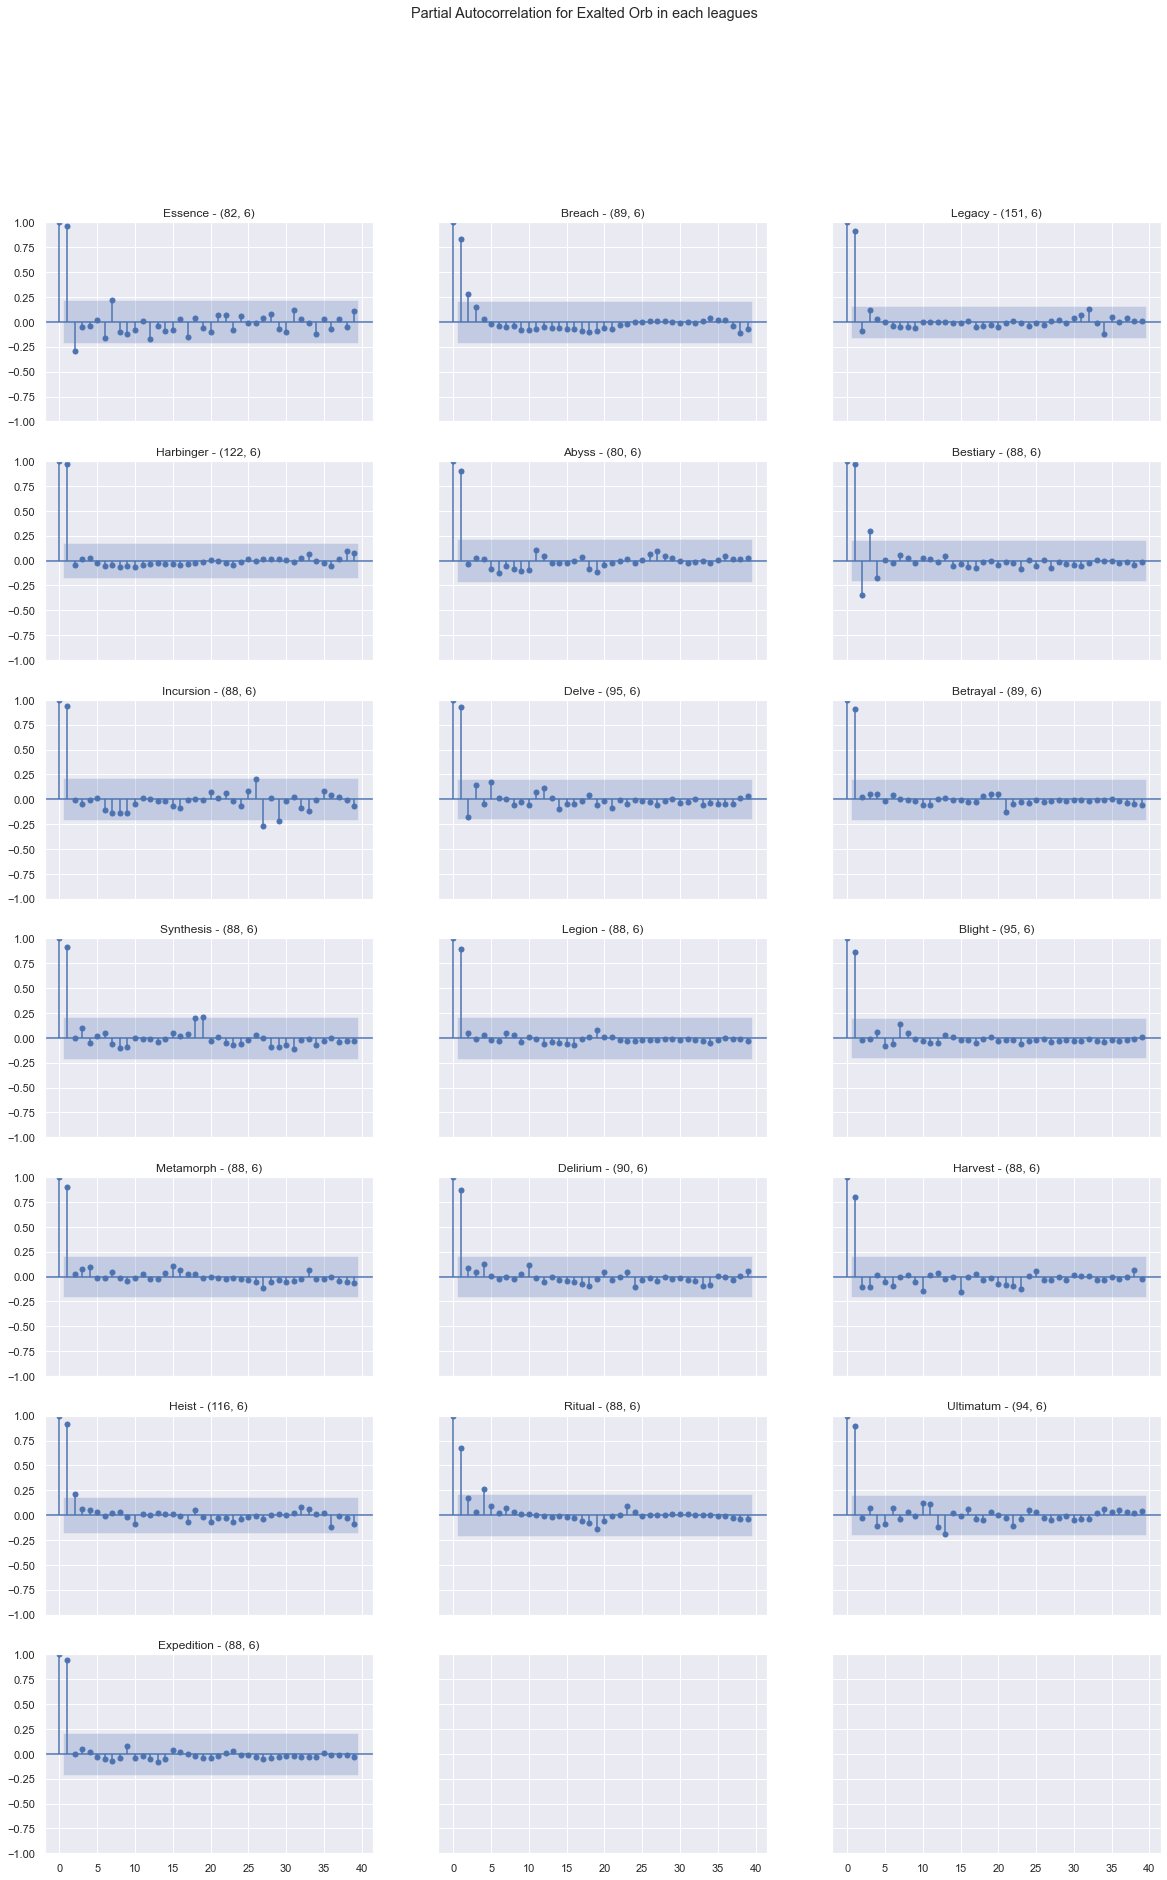

In [65]:
def plot_currency_partial_auto_correlation_leagues_in_grid(name, data, leagues, column = 'Value', figsize = (20,30), lags = 39, save_figure = True):
    league_count = len(leagues)
    n_cols = 3
    figure, axes = plt.subplots(math.ceil(league_count/float(n_cols)), n_cols, figsize = figsize, sharex = True, sharey = True)
    
    current_df_shape = None
    finished = False
    while (not finished):
        try:
            for league, ax in zip(leagues, axes.flatten()):
                df = get_currency_data(name, data,league)
                if df.empty: continue
                current_df_shape = df.shape
                # print('Lag: ', lags, ' current_df_shape:' , current_df_shape)
                plot_pacf(df[column], ax = ax, lags=lags, method='ywm')
                ax.set_title(f'{league} - {df.shape}')
            finished = True
        except ValueError as e:
            print('Error:', e)
            print('Reducing lag to :', current_df_shape[0] // 2)
            lags = current_df_shape[0] // 2 -1
            plt.close()
            figure, axes = plt.subplots(math.ceil(league_count/float(n_cols)), n_cols, figsize = figsize, sharex = True, sharey = True)


    figure.suptitle(f'Partial Autocorrelation for {name} in each leagues')

    save_name = f'value_each_league_partial_autocor_{name}.png'
    if save_figure: plt.savefig(f'{IMG_OUTPUT_PATH}/{save_name}', dpi=DPI_OUTPUT)
    plt.show()

plot_currency_partial_auto_correlation_leagues_in_grid('Exalted Orb', DATA, LEAGUES)

### More Samples
Let's look at others sample 

Autocor of:  Orb of Alteration


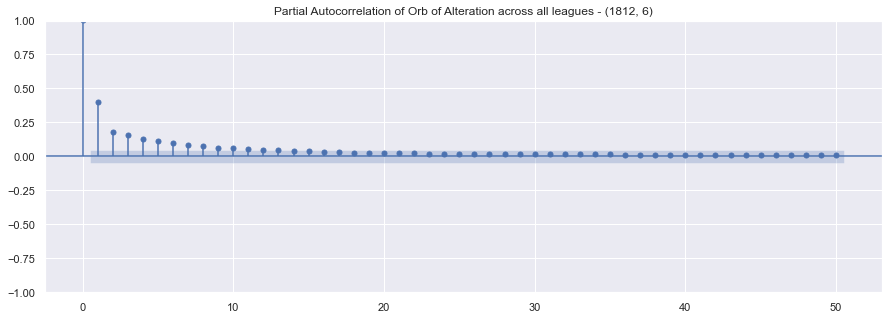

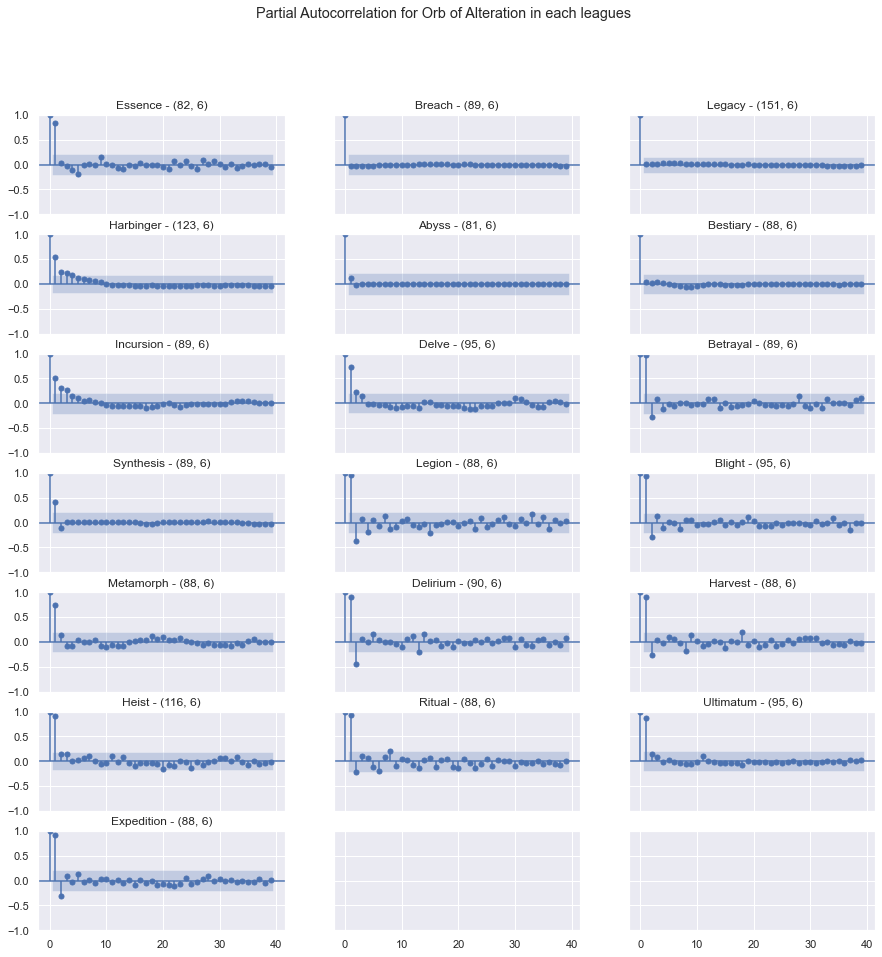

Autocor of:  Offering to the Goddess


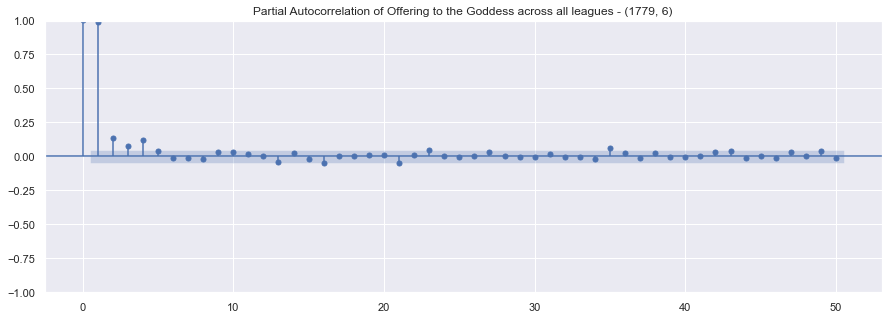

Error: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 39 must be < 33.
Reducing lag to : 33


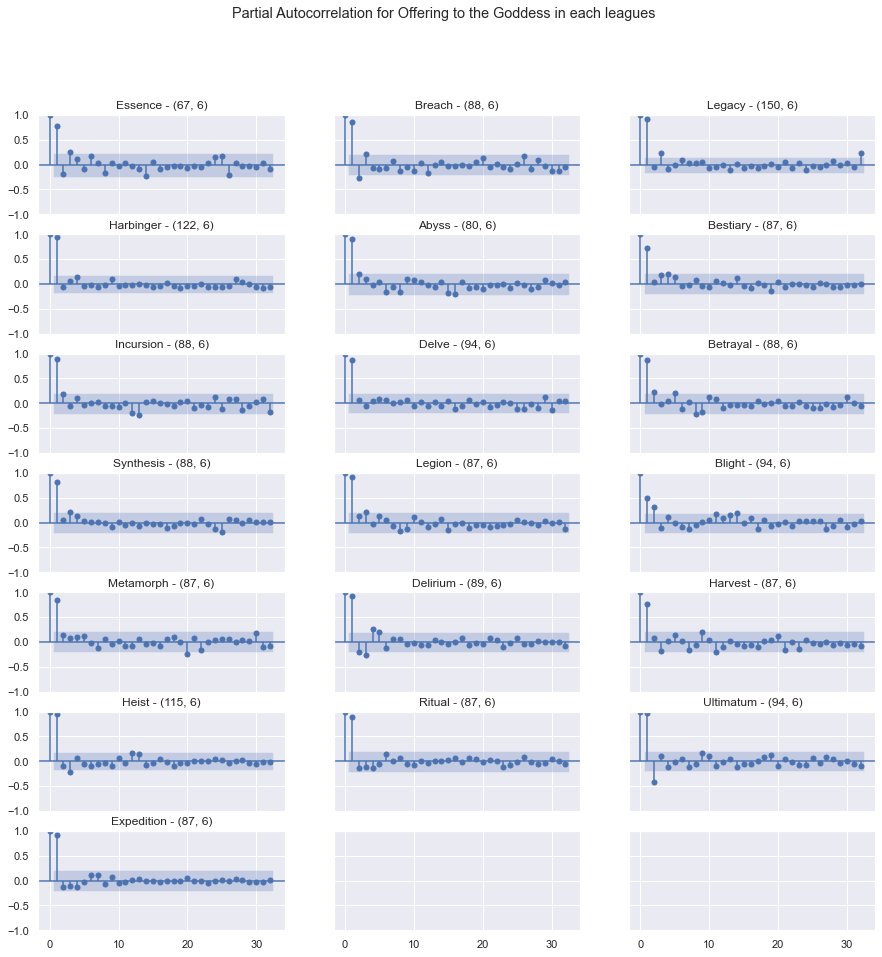

Autocor of:  Vaal Orb


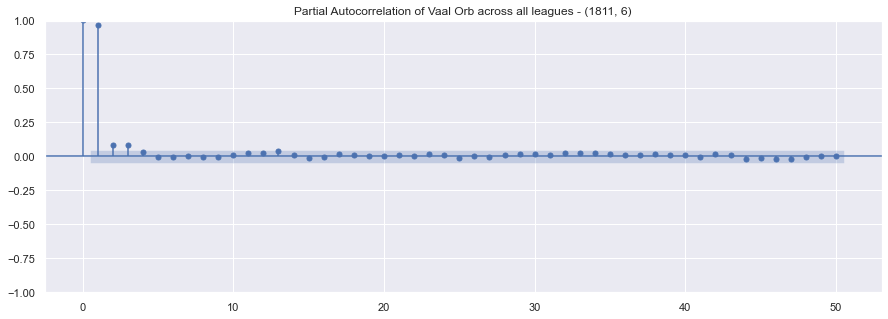

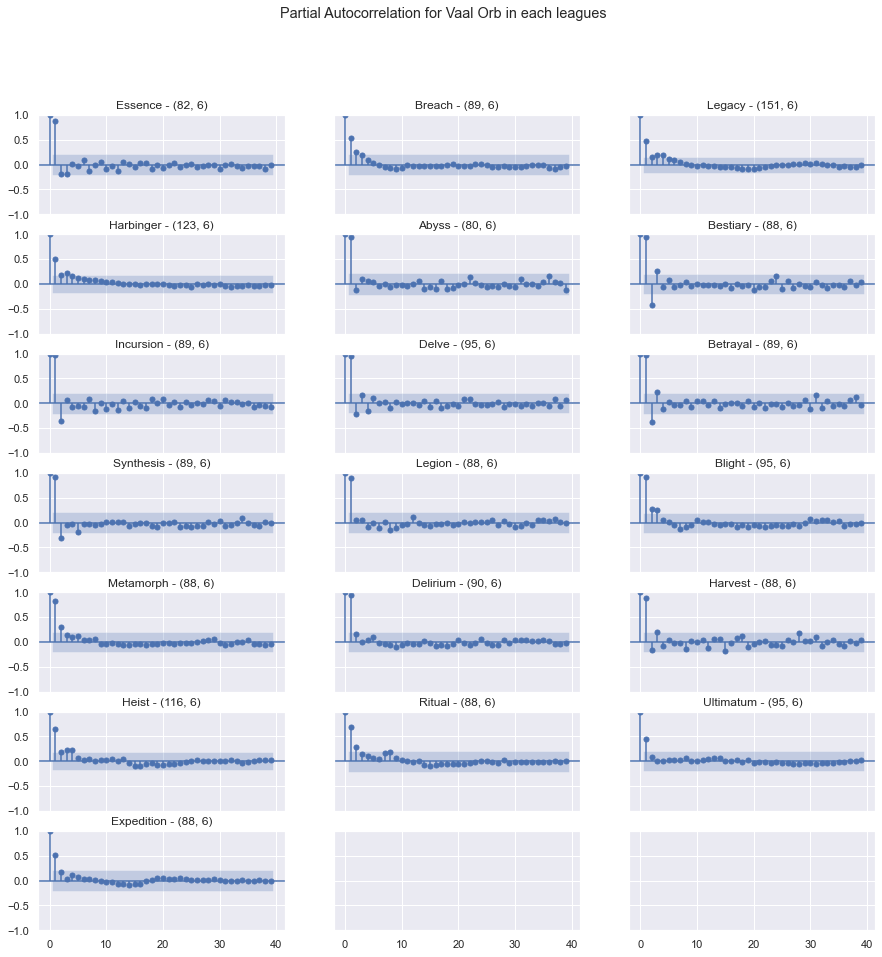

Autocor of:  Divine Orb


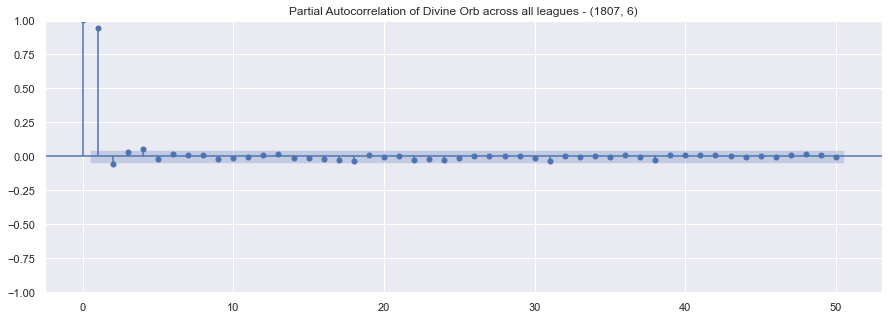

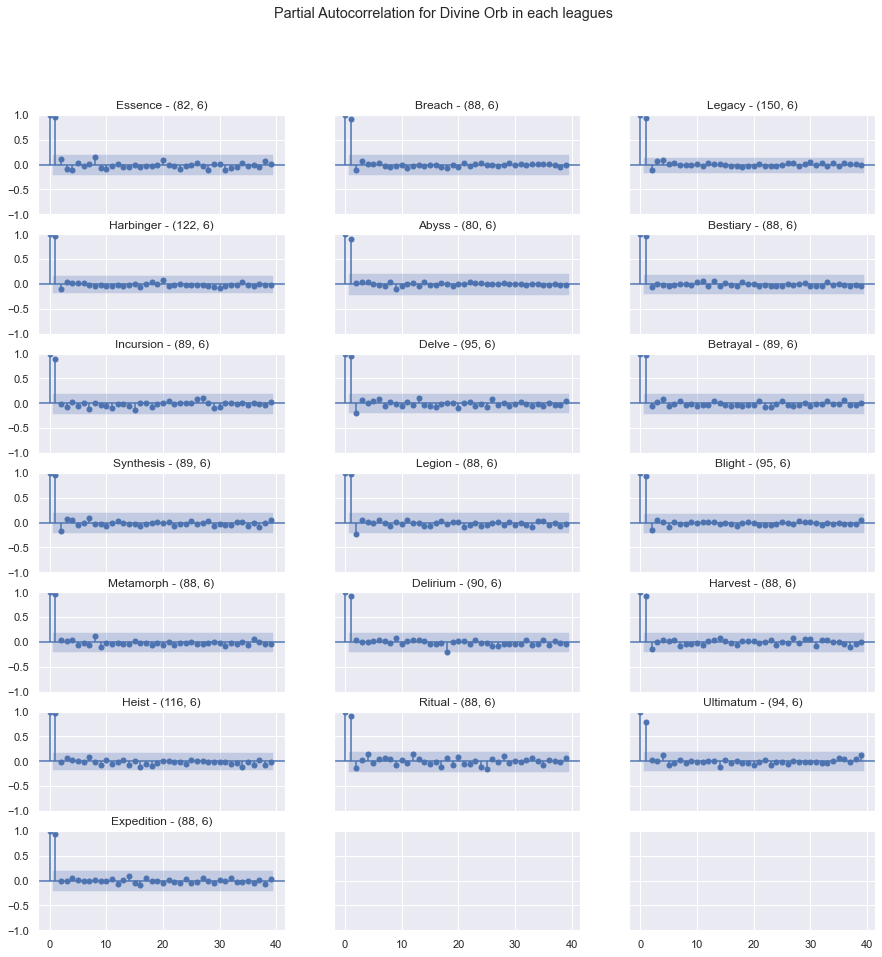

Autocor of:  Exalted Orb


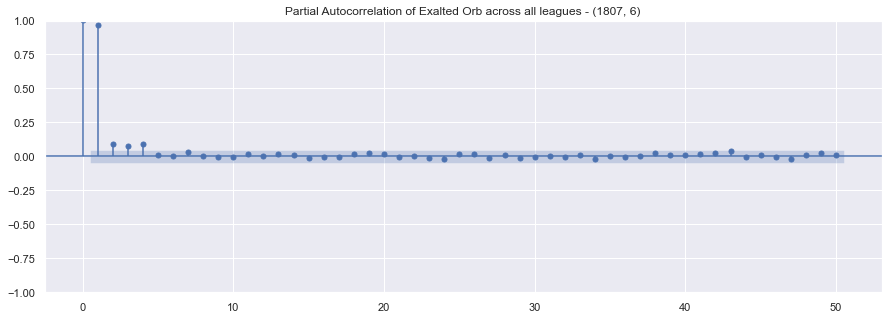

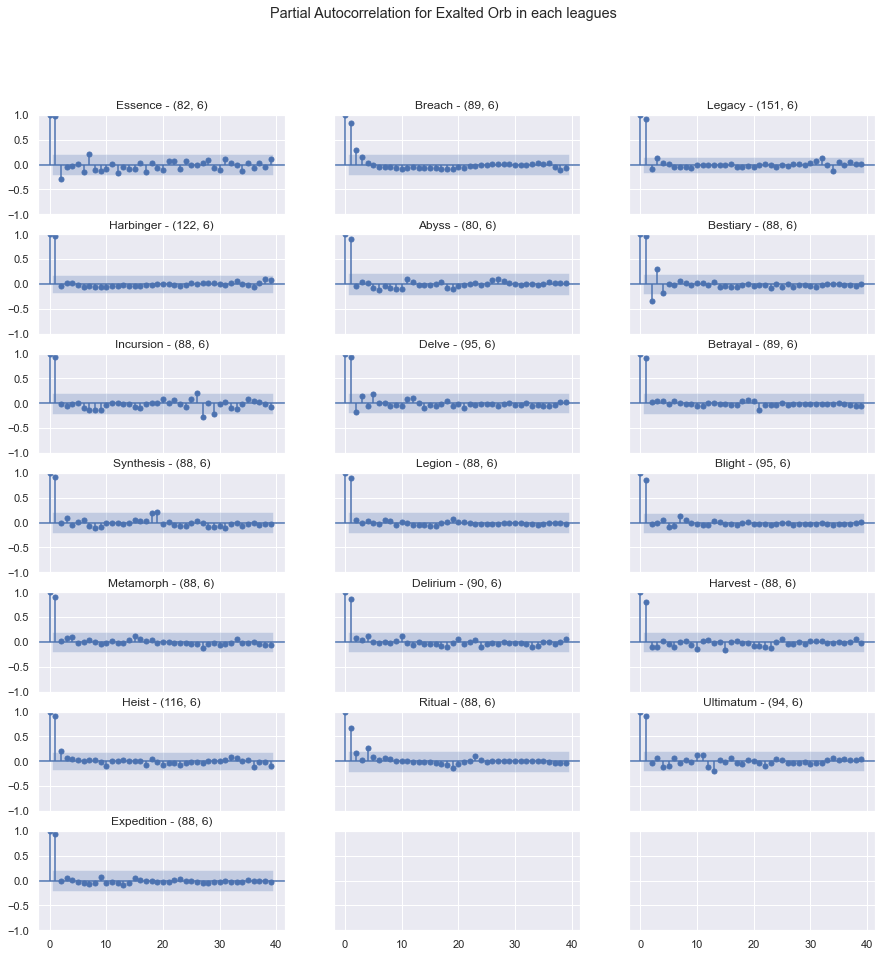

Autocor of:  Chayula's Breachstone


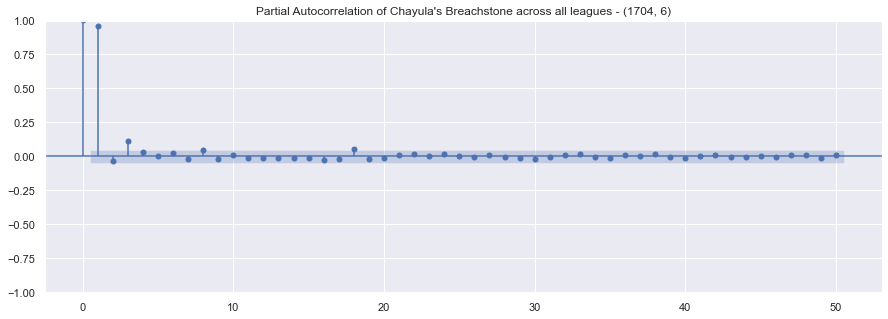

Error: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 39 must be < 39.
Reducing lag to : 39


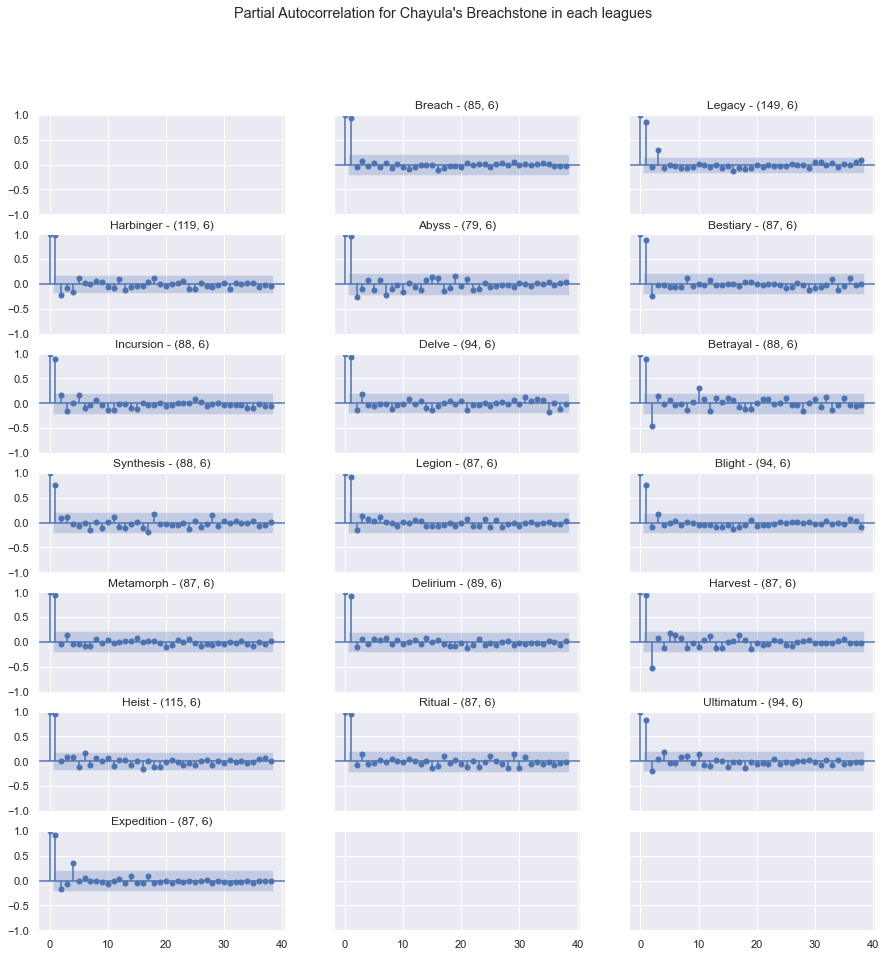

In [66]:
currencies_to_check_partial_auto_cor = INTERESTING_CURRENCIES
for c in currencies_to_check_partial_auto_cor:
    print('Autocor of: ', c)
    plot_currency_partial_auto_correlation_concatinated(c, data = DATA, leagues = LEAGUES, figsize= (15,5))
    plot_currency_partial_auto_correlation_leagues_in_grid(c, data = DATA, leagues = LEAGUES, figsize = (15,15))

## Decomposition

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [96]:
def plot_seasonal_decompose(name, data, leagues, figsize = (20,25), model = 'mul', period = 90):
    decompose_model = 'multiplicative' if model == 'mul' else 'additive'
    merged_df = pd.concat(
        [get_currency_data(name, data, league) for league in leagues]
    ).reset_index(drop=True).sort_values('Date')
    # display(value_series.head())
    result = seasonal_decompose(merged_df['Value'], period=period, model=decompose_model)
    fig = result.plot()
    fig.axes[2].xaxis.set_major_locator(MultipleLocator((period)))
    fig.suptitle(f'{decompose_model} decompose of {name} trend with seasonal period of {period}')
    fig.set_size_inches(figsize)
    plt.show()

### Additive seasonal decomp

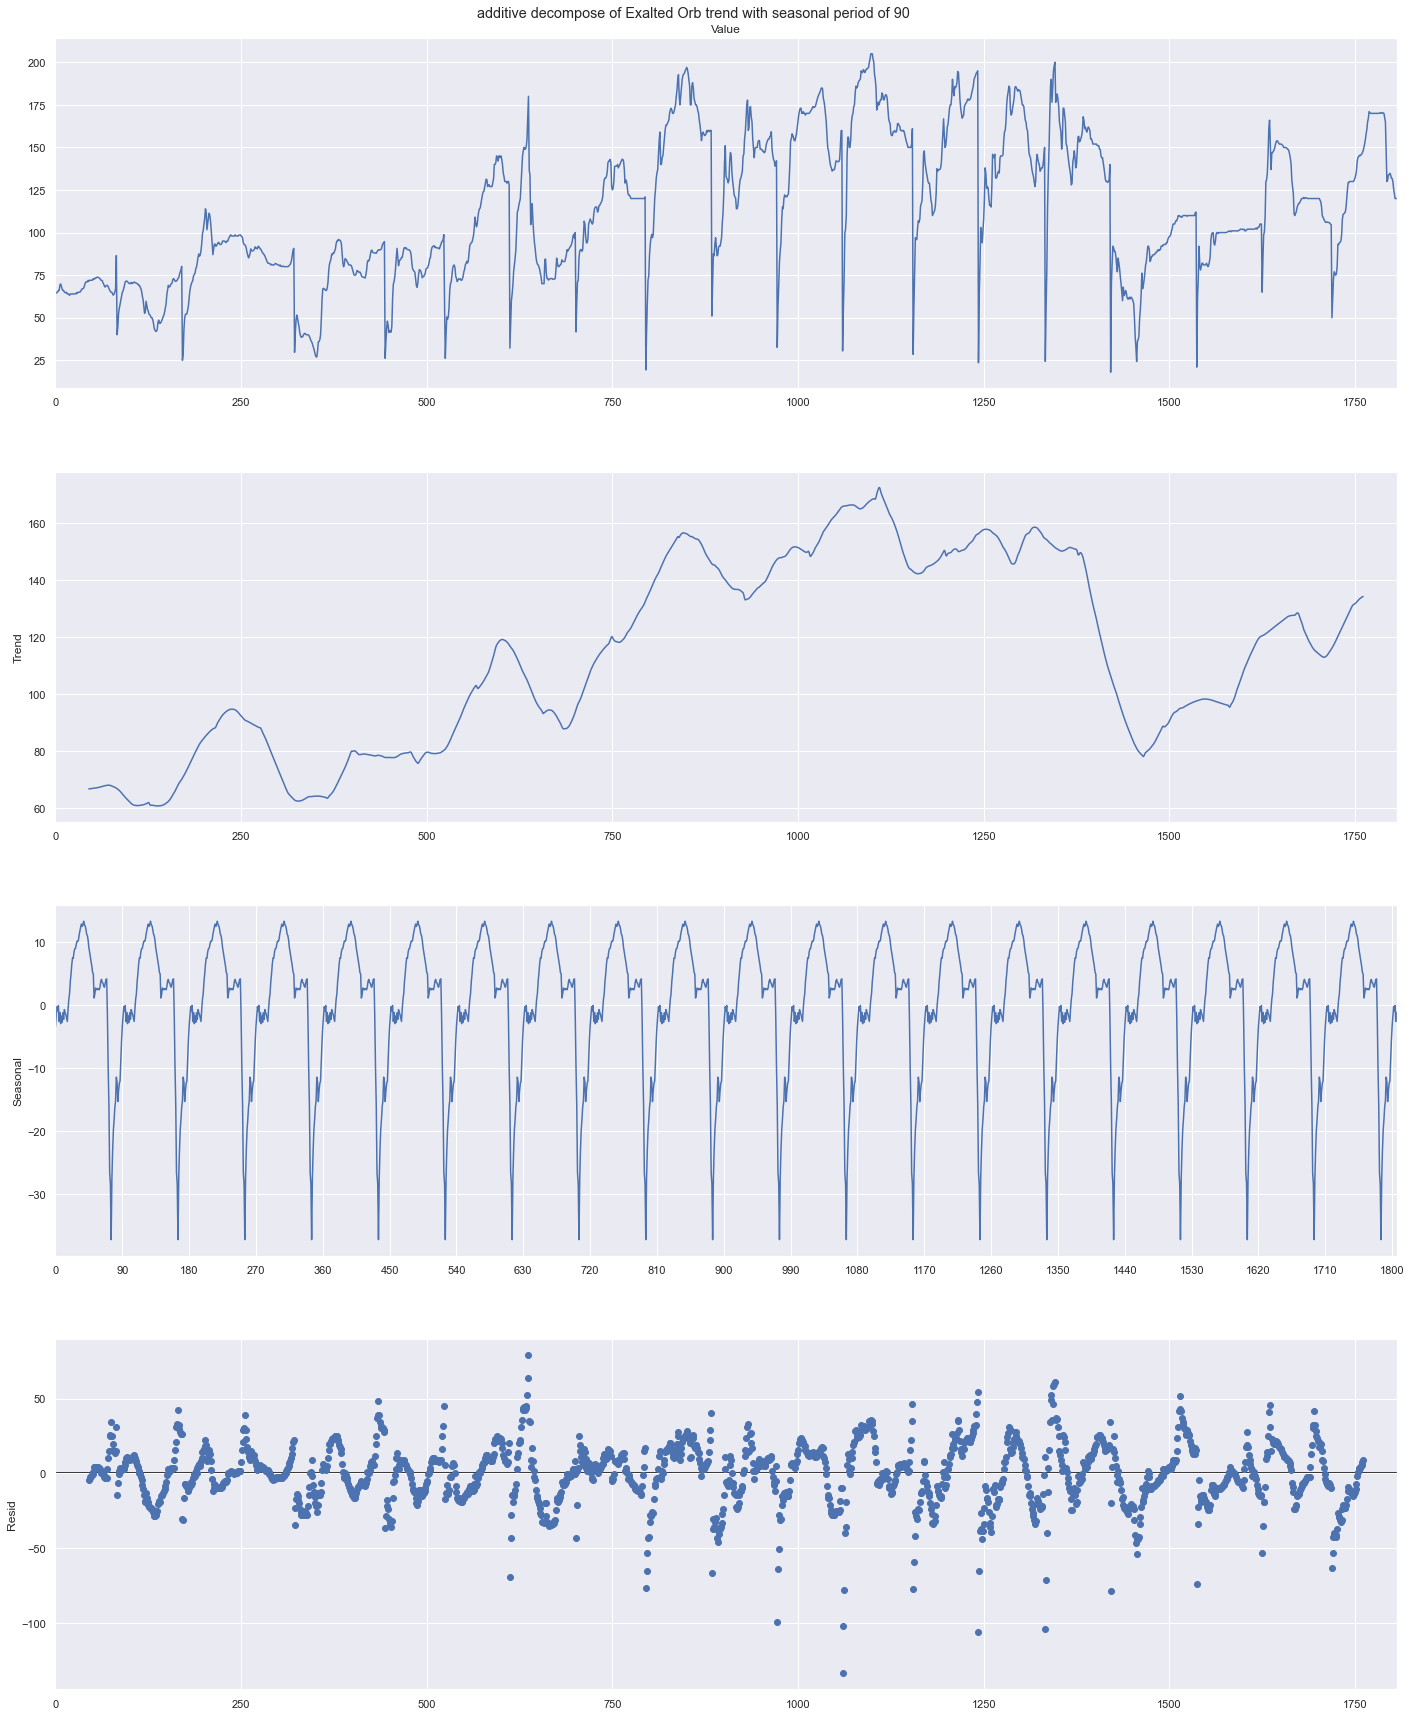

In [97]:
plot_seasonal_decompose('Exalted Orb', DATA, LEAGUES, model = 'add')

### Multiplicative seasonal decomp

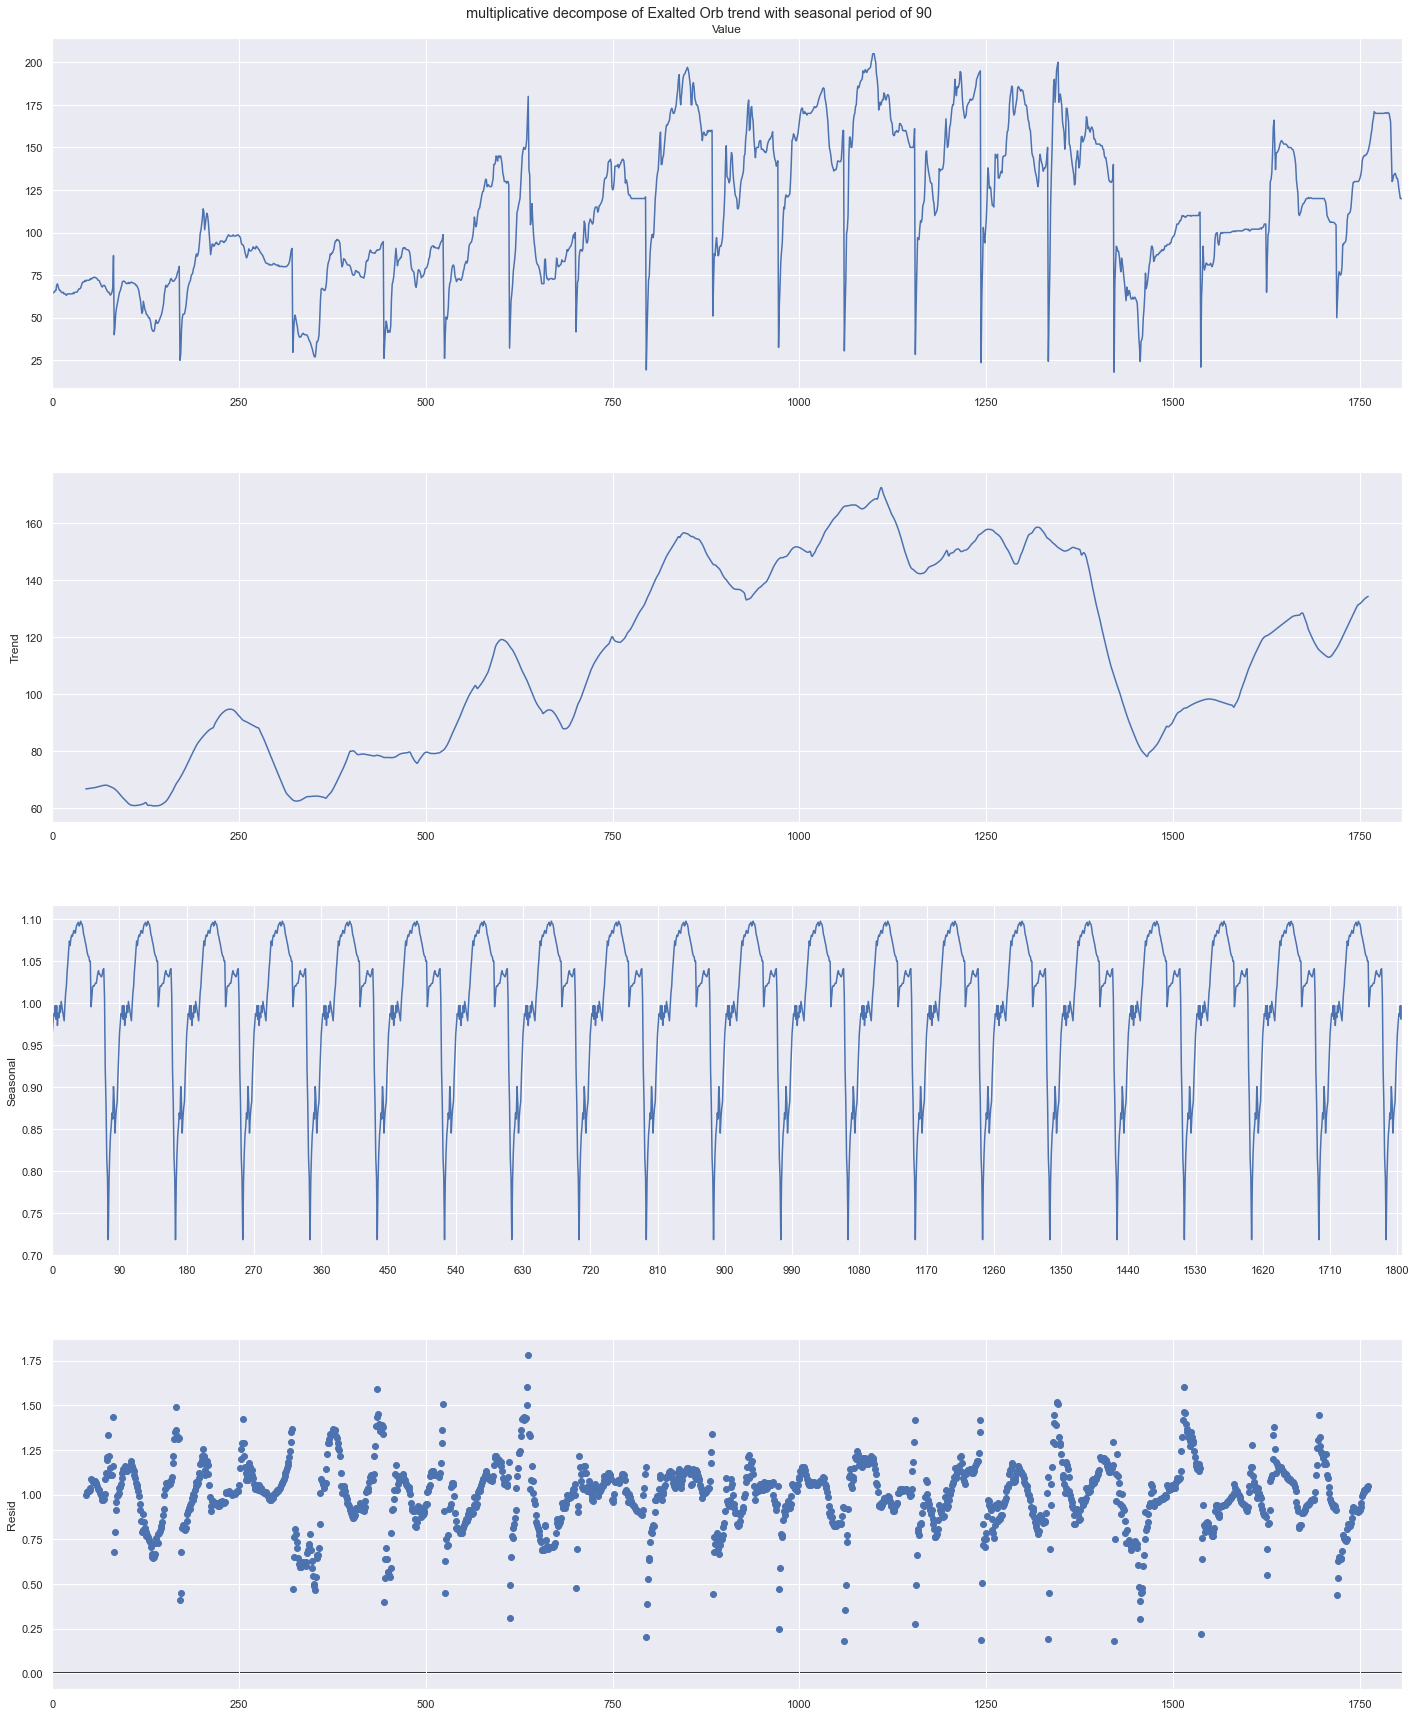

In [98]:
plot_seasonal_decompose('Exalted Orb', DATA, LEAGUES)

### Conclusion decomp
of `Exalted Orb`
- Each league is ~90 days so i choose that as the seasonal period
- Additive model does better than multiplicative
- Because the `Residues` left over by the multi model seems **periodic** and they do not have **zero mean**

# GIANT NOTE:
**`Currently out of exploration ideas, maybe after i get a better understanding of time series by diving into models, i will come back for more EDA`**

## Stationarity
Since our data have no trend, we should determine its stationarity before continuing

####?

####?

## Explore Item Data